<a href="https://colab.research.google.com/github/luuhuynhphuc/colab-project-AI/blob/main/lyft_multi_agent_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRAJECTORY PREDICTION WITH MULTI-AGENT INTERACTION
 Models: Baseline MLP | LSTM Temporal | Transformer Interaction-aware

In [ ]:
#Cell 1: Install denpendencies
# Cell 1: Install dependencies (PIN VERSION for Lyft)
!pip install zarr==2.16.1 numcodecs==0.11.0
!pip install matplotlib scikit-learn tqdm pandas


In [ ]:
#Cell 2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 3: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import zarr
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [ ]:
# Cell 4: Configuration
class Config:
    # Data
    PAST_LEN = 10       # 1 seconds @ 10Hz
    FUTURE_LEN = 10     # 1 seconds @ 10Hz
    INPUT_DIM = 2       # [x, y]
    OUTPUT_DIM = 2      # [x, y]

    # Training
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    EARLY_STOP_PATIENCE = 15

    # Model hyperparameters
    MLP_HIDDEN_DIM = 256
    LSTM_HIDDEN_DIM = 128
    LSTM_NUM_LAYERS = 2
    TRANSFORMER_D_MODEL = 128
    TRANSFORMER_NHEAD = 4
    TRANSFORMER_NUM_LAYERS = 3

    # Data split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15

config = Config()
print("\n" + "="*70)
print("Configuration:")
print("="*70)
for attr in dir(config):
    if not attr.startswith('_'):
        print(f"{attr:25s}: {getattr(config, attr)}")
print("="*70)


Configuration:
BATCH_SIZE               : 64
EARLY_STOP_PATIENCE      : 15
FUTURE_LEN               : 10
INPUT_DIM                : 2
LEARNING_RATE            : 0.001
LSTM_HIDDEN_DIM          : 128
LSTM_NUM_LAYERS          : 2
MLP_HIDDEN_DIM           : 256
NUM_EPOCHS               : 50
OUTPUT_DIM               : 2
PAST_LEN                 : 10
TEST_SPLIT               : 0.15
TRAIN_SPLIT              : 0.7
TRANSFORMER_D_MODEL      : 128
TRANSFORMER_NHEAD        : 4
TRANSFORMER_NUM_LAYERS   : 3
VAL_SPLIT                : 0.15


DATASET PREPARATION

In [ ]:
# Cell 5: Lyft Dataset Loader
class LyftDataset(Dataset):
    def __init__(self, data_path, past_len=20, future_len=30, mode='train', max_samples=5000):
        """
        Args:
            data_path: Path to zarr dataset
            past_len: Number of past timesteps
            future_len: Number of future timesteps
            mode: 'train', 'val', or 'test'
            max_samples: Maximum trajectories to extract
        """
        self.past_len = past_len
        self.future_len = future_len
        self.mode = mode

        print(f"\n{'='*70}")
        print(f"Loading {mode.upper()} dataset from Lyft...")
        print(f"{'='*70}")

        # Load zarr dataset
        self.dataset = zarr.open(data_path, mode='r')
        self.frames = self.dataset['frames'][:]
        self.agents = self.dataset['agents'][:]

        print(f"✓ Loaded {len(self.frames)} frames")
        print(f"✓ Loaded {len(self.agents)} agents")

        # Extract valid trajectories
        self.trajectories = self._extract_trajectories_simple(max_samples)

        # Split data
        self._split_data(mode)

        print(f"✓ {mode.upper()} set: {len(self.data)} samples")
        print(f"{'='*70}\n")

    def _extract_trajectories_simple(self, max_samples):
        """Extract valid trajectories"""
        trajectories = []
        total_frames = len(self.frames)

        print(f"Extracting trajectories (simplified method)...")

        # Sample random frames
        valid_frame_range = range(50, total_frames - 50)
        sampled_frames = np.random.choice(
            list(valid_frame_range),
            size=min(max_samples // 10, len(valid_frame_range)),  # Sample fewer frames
            replace=False
        )

        for frame_idx in tqdm(sampled_frames, desc='Processing frames'):
            frame = self.frames[frame_idx]
            agent_start = frame['agent_index_interval'][0]
            agent_end = frame['agent_index_interval'][1]

            # Get agents in this frame
            for agent_idx in range(agent_start, min(agent_end, len(self.agents))):
                try:
                    agent = self.agents[agent_idx]

                    # Filter: only moving agents
                    speed = np.linalg.norm(agent['velocity'])
                    agent_type = np.argmax(agent['label_probabilities'])

                    # Only vehicles with reasonable speed
                    if speed > 0.5 and speed < 30.0 and agent_type in [0, 3, 14]:
                        # Current position and velocity
                        current_pos = agent['centroid'].copy()
                        velocity = agent['velocity'].copy()

                        # Create SYNTHETIC past trajectory
                        ego_past = self._create_synthetic_past(current_pos, velocity, self.past_len)

                        # Create SYNTHETIC future trajectory
                        ego_future = self._create_synthetic_future(current_pos, velocity, self.future_len)

                        # Get neighbors (also synthetic for simplicity)
                        neighbors_past = self._get_synthetic_neighbors(
                            frame, agent_idx, current_pos, agent_start, agent_end
                        )

                        trajectories.append({
                            'ego_past': ego_past,
                            'ego_future': ego_future,
                            'neighbors_past': neighbors_past
                        })

                        # Stop if we have enough
                        if len(trajectories) >= max_samples:
                            break

                except Exception as e:
                    continue

            if len(trajectories) >= max_samples:
                break

        print(f"✓ Extracted {len(trajectories)} trajectories")
        return trajectories

    def _create_synthetic_past(self, current_pos, velocity, length):
        """Create synthetic past trajectory from current state"""
        trajectory = []
        dt = 0.1  # 10Hz

        for i in range(length, 0, -1):
            # Go back in time
            past_pos = current_pos - velocity * i * dt
            trajectory.append(past_pos.copy())

        return np.array(trajectory, dtype=np.float32)

    def _create_synthetic_future(self, current_pos, velocity, length):
        """Create synthetic future trajectory"""
        trajectory = []
        dt = 0.1

        for i in range(1, length + 1):
            # Go forward in time
            future_pos = current_pos + velocity * i * dt
            trajectory.append(future_pos.copy())

        return np.array(trajectory, dtype=np.float32)

    def _get_synthetic_neighbors(self, frame, ego_agent_idx, ego_pos, agent_start, agent_end):
        """Get synthetic neighbor trajectories"""
        neighbors = []
        max_neighbors = 5

        for neighbor_idx in range(agent_start, min(agent_end, len(self.agents))):
            if neighbor_idx == ego_agent_idx:
                continue

            try:
                neighbor = self.agents[neighbor_idx]
                neighbor_pos = neighbor['centroid']

                # Distance check
                dist = np.linalg.norm(ego_pos - neighbor_pos)

                if dist < 50.0 and len(neighbors) < max_neighbors:
                    # Create synthetic past for neighbor
                    neighbor_velocity = neighbor['velocity']
                    neighbor_past = self._create_synthetic_past(
                        neighbor_pos,
                        neighbor_velocity,
                        self.past_len
                    )
                    neighbors.append(neighbor_past)
            except:
                continue

        # Pad to max_neighbors
        while len(neighbors) < max_neighbors:
            neighbors.append(np.zeros((self.past_len, 2), dtype=np.float32))

        return np.array(neighbors[:max_neighbors], dtype=np.float32)

    def _split_data(self, mode):
        """Split trajectories into train/val/test"""
        n = len(self.trajectories)

        if n == 0:
            print("WARNING: No trajectories extracted!")
            self.data = []
            return

        train_end = int(config.TRAIN_SPLIT * n)
        val_end = int((config.TRAIN_SPLIT + config.VAL_SPLIT) * n)

        if mode == 'train':
            self.data = self.trajectories[:train_end]
        elif mode == 'val':
            self.data = self.trajectories[train_end:val_end]
        else:  # test
            self.data = self.trajectories[val_end:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            ego_past: [past_len, 2]
            ego_future: [future_len, 2]
            neighbors_past: [num_neighbors, past_len, 2]
        """
        sample = self.data[idx]

        ego_past = torch.FloatTensor(sample['ego_past'])
        ego_future = torch.FloatTensor(sample['ego_future'])
        neighbors_past = torch.FloatTensor(sample['neighbors_past'])

        return ego_past, ego_future, neighbors_past

In [ ]:
#Cell 6: Test dataset loading

DATASET_PATH = "/content/drive/MyDrive/Dataset_Lyft_Prediction/sample.zarr"

try:
    # Create datasets
    train_dataset = LyftDataset(DATASET_PATH, config.PAST_LEN, config.FUTURE_LEN, mode='train')
    val_dataset = LyftDataset(DATASET_PATH, config.PAST_LEN, config.FUTURE_LEN, mode='val')
    test_dataset = LyftDataset(DATASET_PATH, config.PAST_LEN, config.FUTURE_LEN, mode='test')

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

    print("\n" + "="*70)
    print("Dataset Summary:")
    print("="*70)
    print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"Val:   {len(val_dataset)} samples, {len(val_loader)} batches")
    print(f"Test:  {len(test_dataset)} samples, {len(test_loader)} batches")
    print("="*70)

    # Test one batch
    ego_past, ego_future, neighbors_past = next(iter(train_loader))
    print(f"\nBatch shapes:")
    print(f"  Ego past:       {ego_past.shape}")      # [batch, past_len, 2]
    print(f"  Ego future:     {ego_future.shape}")    # [batch, future_len, 2]
    print(f"  Neighbors past: {neighbors_past.shape}") # [batch, num_neighbors, past_len, 2]

except FileNotFoundError:
    print(f"\n Dataset not found at: {DATASET_PATH}")
    print("\nPlease:")
    print("1. Upload dataset to Google Drive")
    print("2. Update DATASET_PATH variable")
    print("3. Or upload directly to Colab")


Loading TRAIN dataset from Lyft...
✓ Loaded 24838 frames
✓ Loaded 1893736 agents
Extracting trajectories (simplified method)...


Processing frames: 100%|██████████| 500/500 [00:03<00:00, 136.13it/s]


✓ Extracted 4901 trajectories
✓ TRAIN set: 3430 samples


Loading VAL dataset from Lyft...
✓ Loaded 24838 frames
✓ Loaded 1893736 agents
Extracting trajectories (simplified method)...


Processing frames: 100%|██████████| 500/500 [00:03<00:00, 152.38it/s]


✓ Extracted 4666 trajectories
✓ VAL set: 700 samples


Loading TEST dataset from Lyft...
✓ Loaded 24838 frames
✓ Loaded 1893736 agents
Extracting trajectories (simplified method)...


Processing frames: 100%|██████████| 500/500 [00:04<00:00, 109.58it/s]


✓ Extracted 4504 trajectories
✓ TEST set: 676 samples


Dataset Summary:
Train: 3430 samples, 54 batches
Val:   700 samples, 11 batches
Test:  676 samples, 11 batches

Batch shapes:
  Ego past:       torch.Size([64, 10, 2])
  Ego future:     torch.Size([64, 10, 2])
  Neighbors past: torch.Size([64, 5, 10, 2])


**MODEL 1: BASELINE MLP (NO TEMPORAL, NO INTERACTION) **




In [ ]:
#Cell 7: BASELINE MLP (MLP Model)
class BaselineMLP(nn.Module):
    """
    Simple MLP baseline
    - Flattens past trajectory
    - No temporal modeling
    - No neighbor interaction
    """
    def __init__(self, past_len=10, future_len=10, hidden_dim=256):
        super(BaselineMLP, self).__init__()

        self.past_len = past_len
        self.future_len = future_len

        # Input: flattened past trajectory
        input_dim = past_len * 2
        output_dim = future_len * 2

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),

            nn.Linear(hidden_dim // 2, output_dim)
        )

        print(f"\n{'='*70}")
        print("Baseline MLP Architecture:")
        print(f"{'='*70}")
        print(f"Input:  {input_dim} (flattened past)")
        print(f"Hidden: {hidden_dim} → {hidden_dim} → {hidden_dim//2}")
        print(f"Output: {output_dim} (flattened future)")

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params:,}")
        print(f"{'='*70}\n")

    def forward(self, ego_past, neighbors_past=None):
        """
        Args:
            ego_past: [batch, past_len, 2]
            neighbors_past: ignored (MLP doesn't use neighbors)

        Returns:
            predicted: [batch, future_len, 2]
        """
        batch_size = ego_past.size(0)

        # Flatten past trajectory
        x = ego_past.view(batch_size, -1)  # [batch, past_len * 2]

        # Forward pass
        out = self.network(x)  # [batch, future_len * 2]

        # Reshape to trajectory
        predicted = out.view(batch_size, self.future_len, 2)

        return predicted



In [ ]:
# Cell 8: Test MLP
model_mlp = BaselineMLP(config.PAST_LEN, config.FUTURE_LEN, config.MLP_HIDDEN_DIM).to(device)

# Test forward pass
with torch.no_grad():
    ego_past, ego_future, neighbors_past = next(iter(train_loader))
    ego_past = ego_past.to(device)

    predicted = model_mlp(ego_past)

    print(f"Input shape:  {ego_past.shape}")
    print(f"Output shape: {predicted.shape}")
    print(f"Target shape: {ego_future.shape}")
    print(f"\n✓ MLP model test passed!")


Baseline MLP Architecture:
Input:  20 (flattened past)
Hidden: 256 → 256 → 128
Output: 20 (flattened future)
Total parameters: 106,644

Input shape:  torch.Size([64, 10, 2])
Output shape: torch.Size([64, 10, 2])
Target shape: torch.Size([64, 10, 2])

✓ MLP model test passed!


**MODEL 2: LSTM TEMPORAL (WITH TIME, NO INTERACTION)**

In [13]:
#Cell 9: LSTM Model
class LSTMTemporal(nn.Module):
    """
    LSTM for temporal modeling
    - Processes sequence with LSTM
    - Captures temporal dependencies
    - No neighbor interaction
    """
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=2, future_len=10):
        super(LSTMTemporal, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_len = future_len

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Output projection
        self.fc_out = nn.Linear(hidden_dim, input_dim)

        print(f"\n{'='*70}")
        print("LSTM Temporal Architecture:")
        print(f"{'='*70}")
        print(f"Input dim:   {input_dim}")
        print(f"Hidden dim:  {hidden_dim}")
        print(f"Num layers:  {num_layers}")
        print(f"Future len:  {future_len}")
        print(f"Encoder:     LSTM({input_dim} → {hidden_dim})")
        print(f"Decoder:     LSTM({input_dim} → {hidden_dim})")
        print(f"Output:      Linear({hidden_dim} → {input_dim})")

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params:,}")
        print(f"{'='*70}\n")

    def forward(self, ego_past, neighbors_past=None):
        """
        Args:
            ego_past: [batch, past_len, 2]
            neighbors_past: ignored

        Returns:
            predicted: [batch, future_len, 2]
        """
        batch_size = ego_past.size(0)

        # Encode past trajectory
        _, (h_n, c_n) = self.encoder_lstm(ego_past)
        # h_n, c_n: [num_layers, batch, hidden_dim]

        # Decoder: autoregressive generation
        decoder_input = ego_past[:, -1:, :]  # Last position [batch, 1, 2]

        predictions = []

        for t in range(self.future_len):
            # Decode one step
            decoder_output, (h_n, c_n) = self.decoder_lstm(decoder_input, (h_n, c_n))
            # decoder_output: [batch, 1, hidden_dim]

            # Project to position
            pred = self.fc_out(decoder_output)  # [batch, 1, 2]
            predictions.append(pred)

            # Use prediction as next input
            decoder_input = pred

        # Concatenate predictions
        predicted = torch.cat(predictions, dim=1)  # [batch, future_len, 2]

        return predicted



In [14]:
# Cell 10: Test LSTM
model_lstm = LSTMTemporal(
    config.INPUT_DIM,
    config.LSTM_HIDDEN_DIM,
    config.LSTM_NUM_LAYERS,
    config.FUTURE_LEN
).to(device)

# Test forward pass
with torch.no_grad():
    ego_past = ego_past.to(device)
    predicted = model_lstm(ego_past)

    print(f"Input shape:  {ego_past.shape}")
    print(f"Output shape: {predicted.shape}")
    print(f"\n✓ LSTM model test passed!")


LSTM Temporal Architecture:
Input dim:   2
Hidden dim:  128
Num layers:  2
Future len:  10
Encoder:     LSTM(2 → 128)
Decoder:     LSTM(2 → 128)
Output:      Linear(128 → 2)
Total parameters: 399,618

Input shape:  torch.Size([64, 10, 2])
Output shape: torch.Size([64, 10, 2])

✓ LSTM model test passed!


MODEL 3: TRANSFORMER (WITH TIME + INTERACTION)

In [15]:
# Cell 11: Transformer Model
class TransformerInteractionAware(nn.Module):
    """
    Transformer for trajectory prediction with neighbor interaction
    - Self-attention captures temporal dependencies
    - Cross-attention models agent interactions
    """
    def __init__(
        self,
        input_dim=2,
        d_model=128,
        nhead=4,
        num_layers=3,
        future_len=30
    ):
        super(TransformerInteractionAware, self).__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.future_len = future_len

        # Input embedding
        self.input_embedding = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer encoder (for both ego and neighbors)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Interaction: Cross-attention between ego and neighbors
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=0.1,
            batch_first=True
        )

        # Decoder for future prediction
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        # Output projection
        self.fc_out = nn.Linear(d_model, input_dim)

        # Learnable query for future
        self.future_query = nn.Parameter(torch.randn(1, future_len, d_model))

        print(f"\n{'='*70}")
        print("Transformer Interaction-Aware Architecture:")
        print(f"{'='*70}")
        print(f"Input dim:       {input_dim}")
        print(f"Model dim:       {d_model}")
        print(f"Attention heads: {nhead}")
        print(f"Encoder layers:  {num_layers}")
        print(f"Decoder layers:  {num_layers}")
        print(f"Future length:   {future_len}")
        print(f"")
        print(f"Components:")
        print(f"  1. Input Embedding: Linear({input_dim} → {d_model})")
        print(f"  2. Positional Encoding")
        print(f"  3. Transformer Encoder (self-attention)")
        print(f"  4. Cross-Attention (ego ↔ neighbors)")
        print(f"  5. Transformer Decoder")
        print(f"  6. Output Projection: Linear({d_model} → {input_dim})")

        total_params = sum(p.numel() for p in self.parameters())
        print(f"\nTotal parameters: {total_params:,}")
        print(f"{'='*70}\n")

    def forward(self, ego_past, neighbors_past):
        """
        Args:
            ego_past: [batch, past_len, 2]
            neighbors_past: [batch, num_neighbors, past_len, 2]

        Returns:
            predicted: [batch, future_len, 2]
        """
        batch_size = ego_past.size(0)
        past_len = ego_past.size(1)
        num_neighbors = neighbors_past.size(1)

        # Embed ego trajectory
        ego_embedded = self.input_embedding(ego_past)  # [batch, past_len, d_model]
        ego_embedded = self.pos_encoder(ego_embedded)

        # Encode ego trajectory
        ego_encoded = self.transformer_encoder(ego_embedded)  # [batch, past_len, d_model]

        # If there are neighbors, model interaction
        if num_neighbors > 0:
            # Reshape neighbors: [batch * num_neighbors, past_len, 2]
            neighbors_flat = neighbors_past.view(batch_size * num_neighbors, past_len, self.input_dim)

            # Embed neighbors
            neighbors_embedded = self.input_embedding(neighbors_flat)
            neighbors_embedded = self.pos_encoder(neighbors_embedded)

            # Encode neighbors
            neighbors_encoded = self.transformer_encoder(neighbors_embedded)
            # [batch * num_neighbors, past_len, d_model]

            # Reshape back: [batch, num_neighbors, past_len, d_model]
            neighbors_encoded = neighbors_encoded.view(
                batch_size, num_neighbors, past_len, self.d_model
            )

            # Pool neighbors over time: [batch, num_neighbors, d_model]
            neighbors_pooled = neighbors_encoded.mean(dim=2)

            # Cross-attention: ego attend to neighbors
            # ego_encoded: [batch, past_len, d_model]
            # neighbors_pooled: [batch, num_neighbors, d_model]
            ego_with_interaction, _ = self.cross_attention(
                query=ego_encoded,
                key=neighbors_pooled,
                value=neighbors_pooled
            )
            # ego_with_interaction: [batch, past_len, d_model]

            # Combine ego and interaction
            memory = ego_with_interaction
        else:
            memory = ego_encoded

        # Prepare future queries
        future_query = self.future_query.expand(batch_size, -1, -1)  # [batch, future_len, d_model]

        # Decode future
        decoded = self.transformer_decoder(future_query, memory)  # [batch, future_len, d_model]

        # Project to positions
        predicted = self.fc_out(decoded)  # [batch, future_len, 2]

        return predicted

class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

In [16]:
# Cell 12: Test Transformer
model_transformer = TransformerInteractionAware(
    config.INPUT_DIM,
    config.TRANSFORMER_D_MODEL,
    config.TRANSFORMER_NHEAD,
    config.TRANSFORMER_NUM_LAYERS,
    config.FUTURE_LEN
).to(device)

# Test forward pass
with torch.no_grad():
    ego_past = ego_past.to(device)
    neighbors_past = neighbors_past.to(device)

    predicted = model_transformer(ego_past, neighbors_past)

    print(f"Ego past shape:     {ego_past.shape}")
    print(f"Neighbors past shape: {neighbors_past.shape}")
    print(f"Output shape:       {predicted.shape}")
    print(f"\n✓ Transformer model test passed!")


Transformer Interaction-Aware Architecture:
Input dim:       2
Model dim:       128
Attention heads: 4
Encoder layers:  3
Decoder layers:  3
Future length:   10

Components:
  1. Input Embedding: Linear(2 → 128)
  2. Positional Encoding
  3. Transformer Encoder (self-attention)
  4. Cross-Attention (ego ↔ neighbors)
  5. Transformer Decoder
  6. Output Projection: Linear(128 → 2)

Total parameters: 1,456,514

Ego past shape:     torch.Size([64, 10, 2])
Neighbors past shape: torch.Size([64, 5, 10, 2])
Output shape:       torch.Size([64, 10, 2])

✓ Transformer model test passed!


LOSS FUNCTIONS & EVALUATION **METRICS**

In [17]:
# Cell 13: Loss and Metrics
class TrajectoryLoss(nn.Module):
    """Combined loss for trajectory prediction"""
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predicted, target):
        """
        Args:
            predicted: [batch, future_len, 2]
            target: [batch, future_len, 2]

        Returns:
            loss: scalar
        """
        # MSE loss
        loss = self.mse(predicted, target)
        return loss

def calculate_ade(predicted, target):
    """
    Average Displacement Error

    Args:
        predicted: [batch, future_len, 2]
        target: [batch, future_len, 2]

    Returns:
        ade: scalar (meters)
    """
    # Euclidean distance at each timestep
    distances = torch.sqrt(((predicted - target) ** 2).sum(dim=-1))  # [batch, future_len]

    # Average over time and batch
    ade = distances.mean()

    return ade.item()

def calculate_fde(predicted, target):
    """
    Final Displacement Error

    Args:
        predicted: [batch, future_len, 2]
        target: [batch, future_len, 2]

    Returns:
        fde: scalar (meters)
    """
    # Distance at final timestep
    final_pred = predicted[:, -1, :]  # [batch, 2]
    final_target = target[:, -1, :]   # [batch, 2]

    distances = torch.sqrt(((final_pred - final_target) ** 2).sum(dim=-1))  # [batch]

    # Average over batch
    fde = distances.mean()

    return fde.item()

In [18]:
# Cell 14: Test metrics
with torch.no_grad():
    # Create dummy predictions
    predicted = torch.randn(32, 30, 2).to(device)
    target = torch.randn(32, 30, 2).to(device)
# Calculate metrics
loss_fn = TrajectoryLoss()
loss = loss_fn(predicted, target)
ade = calculate_ade(predicted, target)
fde = calculate_fde(predicted, target)

print(f"Loss (MSE): {loss.item():.4f}")
print(f"ADE:        {ade:.4f} meters")
print(f"FDE:        {fde:.4f} meters")
print(f"\n✓ Metrics test passed!")

Loss (MSE): 1.9650
ADE:        1.7602 meters
FDE:        1.5422 meters

✓ Metrics test passed!


TRAINING LOOP & EARLY STOPPING

In [19]:
# Cell 15: Early Stopping
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=15, min_delta=0.0001, verbose=True):
        """
        Args:
            patience: How many epochs to wait after last improvement
            min_delta: Minimum change to qualify as improvement
            verbose: Print messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'  Early stopping triggered! Best epoch: {self.best_epoch}')
        else:
            if self.verbose:
                print(f'  ✓ Validation loss improved: {self.best_loss:.6f} → {val_loss:.6f}')
            self.best_loss = val_loss
            self.save_checkpoint(model, epoch)
            self.counter = 0

    def save_checkpoint(self, model, epoch):
        """Save model when validation loss decreases"""
        self.best_model_state = {
            k: v.cpu().clone() for k, v in model.state_dict().items()
        }
        self.best_epoch = epoch

In [24]:
# Cell 16: Trainer Class
class Trainer:
    """Trainer for trajectory prediction models"""
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        model_name,
        device='cuda',
        learning_rate=0.001,
        num_epochs=100,
        early_stopping_patience=15
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model_name = model_name
        self.device = device
        self.num_epochs = num_epochs

        # Loss function
        self.criterion = TrajectoryLoss()

        # Optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            verbose=True
        )

        # History
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_ade': [],
            'val_ade': [],
            'train_fde': [],
            'val_fde': [],
            'learning_rate': []
        }

        print(f"\n{'='*70}")
        print(f"Trainer initialized for: {model_name}")
        print(f"{'='*70}")
        print(f"Device:           {device}")
        print(f"Learning rate:    {learning_rate}")
        print(f"Max epochs:       {num_epochs}")
        print(f"Early stop patience: {early_stopping_patience}")
        print(f"Optimizer:        Adam")
        print(f"Scheduler:        ReduceLROnPlateau")
        print(f"{'='*70}\n")

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()

        total_loss = 0
        total_ade = 0
        total_fde = 0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc='Training', leave=False)

        for ego_past, ego_future, neighbors_past in pbar:
            # Move to device
            ego_past = ego_past.to(self.device)
            ego_future = ego_future.to(self.device)
            neighbors_past = neighbors_past.to(self.device)

            # Forward pass
            if 'Transformer' in self.model_name:
                predicted = self.model(ego_past, neighbors_past)
            else:
                predicted = self.model(ego_past)

            # Compute loss
            loss = self.criterion(predicted, ego_future)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)

            self.optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                ade = calculate_ade(predicted, ego_future)
                fde = calculate_fde(predicted, ego_future)

            total_loss += loss.item()
            total_ade += ade
            total_fde += fde
            num_batches += 1

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'ade': f'{ade:.2f}',
                'fde': f'{fde:.2f}'
            })

        avg_loss = total_loss / num_batches
        avg_ade = total_ade / num_batches
        avg_fde = total_fde / num_batches

        return avg_loss, avg_ade, avg_fde

    def validate(self):
        """Validate model"""
        self.model.eval()

        total_loss = 0
        total_ade = 0
        total_fde = 0
        num_batches = 0

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation', leave=False)

            for ego_past, ego_future, neighbors_past in pbar:
                # Move to device
                ego_past = ego_past.to(self.device)
                ego_future = ego_future.to(self.device)
                neighbors_past = neighbors_past.to(self.device)

                # Forward pass
                if 'Transformer' in self.model_name:
                    predicted = self.model(ego_past, neighbors_past)
                else:
                    predicted = self.model(ego_past)

                # Compute metrics
                loss = self.criterion(predicted, ego_future)
                ade = calculate_ade(predicted, ego_future)
                fde = calculate_fde(predicted, ego_future)

                total_loss += loss.item()
                total_ade += ade
                total_fde += fde
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'ade': f'{ade:.2f}',
                    'fde': f'{fde:.2f}'
                })

        avg_loss = total_loss / num_batches
        avg_ade = total_ade / num_batches
        avg_fde = total_fde / num_batches

        return avg_loss, avg_ade, avg_fde

    def train(self):
        """Full training loop"""
        print(f"\n{'='*70}")
        print(f"Training {self.model_name}")
        print(f"{'='*70}\n")

        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch+1}/{self.num_epochs}")
            print("-" * 70)

            # Train
            train_loss, train_ade, train_fde = self.train_epoch()

            # Validate
            val_loss, val_ade, val_fde = self.validate()

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_ade'].append(train_ade)
            self.history['val_ade'].append(val_ade)
            self.history['train_fde'].append(train_fde)
            self.history['val_fde'].append(val_fde)
            self.history['learning_rate'].append(current_lr)

            # Print summary
            print(f"\nResults:")
            print(f"  Train - Loss: {train_loss:.4f}, ADE: {train_ade:.2f}m, FDE: {train_fde:.2f}m")
            print(f"  Val   - Loss: {val_loss:.4f}, ADE: {val_ade:.2f}m, FDE: {val_fde:.2f}m")
            print(f"  LR: {current_lr:.6f}")

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Early stopping check
            self.early_stopping(val_loss, self.model, epoch+1)

            if self.early_stopping.early_stop:
                print(f"\n{'='*70}")
                print(f"Early stopping at epoch {epoch+1}")
                print(f"{'='*70}")
                break

            print()

        # Load best model
        if self.early_stopping.best_model_state is not None:
            self.model.load_state_dict(self.early_stopping.best_model_state)
            print(f"\n✓ Loaded best model from epoch {self.early_stopping.best_epoch}")

        print(f"\n{'='*70}")
        print(f"Training {self.model_name} completed!")
        print(f"{'='*70}\n")

        return self.history


TRAIN ALL **MODELS**

In [26]:
# Cell 17: Train Baseline MLP
print("\n" + "="*70)
print("TRAINING MODEL 1: BASELINE MLP")
print("="*70)

model_mlp = BaselineMLP(
    config.PAST_LEN,
    config.FUTURE_LEN,
    config.MLP_HIDDEN_DIM
).to(device)

trainer_mlp = Trainer(
    model=model_mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Baseline MLP",
    device=device,
    learning_rate=config.LEARNING_RATE,
    num_epochs=config.NUM_EPOCHS,
    early_stopping_patience=config.EARLY_STOP_PATIENCE
)

history_mlp = trainer_mlp.train()

# Save model
torch.save(model_mlp.state_dict(), 'model_mlp_best.pth')
print("✓ Model saved: model_mlp_best.pth\n")


TRAINING MODEL 1: BASELINE MLP

Baseline MLP Architecture:
Input:  20 (flattened past)
Hidden: 256 → 256 → 128
Output: 20 (flattened future)
Total parameters: 106,644


Trainer initialized for: Baseline MLP
Device:           cuda
Learning rate:    0.001
Max epochs:       50
Early stop patience: 15
Optimizer:        Adam
Scheduler:        ReduceLROnPlateau


Training Baseline MLP

Epoch 1/50
----------------------------------------------------------------------



Results:
  Train - Loss: 109136.2843, ADE: 332.20m, FDE: 326.04m
  Val   - Loss: 2103.5466, ADE: 54.09m, FDE: 48.68m
  LR: 0.001000

Epoch 2/50
----------------------------------------------------------------------



Results:
  Train - Loss: 7131.6332, ADE: 97.75m, FDE: 97.87m
  Val   - Loss: 1563.0819, ADE: 46.98m, FDE: 47.64m
  LR: 0.001000
  ✓ Validation loss improved: 2103.546642 → 1563.081887

Epoch 3/50
----------------------------------------------------------------------



Results:
  Train - Loss: 6070.9945, ADE: 88.32m, FDE: 88.82m
  Val   - Loss: 1033.4004, ADE: 40.15m, FDE: 41.28m
  LR: 0.001000
  ✓ Validation loss improved: 1563.081887 → 1033.400413

Epoch 4/50
----------------------------------------------------------------------



Results:
  Train - Loss: 5668.5389, ADE: 84.93m, FDE: 86.04m
  Val   - Loss: 1259.0738, ADE: 42.77m, FDE: 45.20m
  LR: 0.001000
  EarlyStopping counter: 1/15

Epoch 5/50
----------------------------------------------------------------------



Results:
  Train - Loss: 5522.5245, ADE: 84.60m, FDE: 85.92m
  Val   - Loss: 2623.2831, ADE: 64.69m, FDE: 70.62m
  LR: 0.001000
  EarlyStopping counter: 2/15

Epoch 6/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4955.5256, ADE: 79.10m, FDE: 80.32m
  Val   - Loss: 644.6606, ADE: 31.16m, FDE: 28.09m
  LR: 0.001000
  ✓ Validation loss improved: 1033.400413 → 644.660578

Epoch 7/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4809.9434, ADE: 78.79m, FDE: 79.25m
  Val   - Loss: 1325.3583, ADE: 43.46m, FDE: 42.77m
  LR: 0.001000
  EarlyStopping counter: 1/15

Epoch 8/50
----------------------------------------------------------------------



Results:
  Train - Loss: 5033.8326, ADE: 80.41m, FDE: 81.22m
  Val   - Loss: 405.9593, ADE: 22.22m, FDE: 23.71m
  LR: 0.001000
  ✓ Validation loss improved: 644.660578 → 405.959299

Epoch 9/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4678.3776, ADE: 76.81m, FDE: 77.35m
  Val   - Loss: 1519.3651, ADE: 47.22m, FDE: 49.34m
  LR: 0.001000
  EarlyStopping counter: 1/15

Epoch 10/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4731.1699, ADE: 77.15m, FDE: 78.00m
  Val   - Loss: 3806.0295, ADE: 72.09m, FDE: 72.65m
  LR: 0.001000
  EarlyStopping counter: 2/15

Epoch 11/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4478.8678, ADE: 75.19m, FDE: 76.24m
  Val   - Loss: 433.3826, ADE: 25.41m, FDE: 29.13m
  LR: 0.001000
  EarlyStopping counter: 3/15

Epoch 12/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4258.2568, ADE: 73.90m, FDE: 74.72m
  Val   - Loss: 410.9098, ADE: 22.79m, FDE: 24.27m
  LR: 0.001000
  EarlyStopping counter: 4/15

Epoch 13/50
----------------------------------------------------------------------



Results:
  Train - Loss: 5122.5879, ADE: 79.53m, FDE: 80.44m
  Val   - Loss: 2355.4633, ADE: 65.17m, FDE: 66.08m
  LR: 0.001000
  EarlyStopping counter: 5/15

Epoch 14/50
----------------------------------------------------------------------



Results:
  Train - Loss: 4065.7314, ADE: 71.87m, FDE: 72.57m
  Val   - Loss: 1878.9732, ADE: 54.12m, FDE: 51.64m
  LR: 0.001000
  EarlyStopping counter: 6/15

Epoch 15/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3897.4465, ADE: 70.21m, FDE: 71.31m
  Val   - Loss: 396.7021, ADE: 25.18m, FDE: 25.78m
  LR: 0.000500
  ✓ Validation loss improved: 405.959299 → 396.702086

Epoch 16/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3746.0160, ADE: 68.60m, FDE: 69.79m
  Val   - Loss: 446.6416, ADE: 25.93m, FDE: 28.25m
  LR: 0.000500
  EarlyStopping counter: 1/15

Epoch 17/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3817.1645, ADE: 68.72m, FDE: 69.59m
  Val   - Loss: 255.6353, ADE: 18.93m, FDE: 19.99m
  LR: 0.000500
  ✓ Validation loss improved: 396.702086 → 255.635331

Epoch 18/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3609.8992, ADE: 67.19m, FDE: 68.44m
  Val   - Loss: 254.4188, ADE: 18.10m, FDE: 21.15m
  LR: 0.000500
  ✓ Validation loss improved: 255.635331 → 254.418788

Epoch 19/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3787.2180, ADE: 68.62m, FDE: 69.20m
  Val   - Loss: 2216.8725, ADE: 50.93m, FDE: 49.70m
  LR: 0.000500
  EarlyStopping counter: 1/15

Epoch 20/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3454.9569, ADE: 65.98m, FDE: 66.90m
  Val   - Loss: 1148.8173, ADE: 41.89m, FDE: 40.48m
  LR: 0.000500
  EarlyStopping counter: 2/15

Epoch 21/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3746.3608, ADE: 68.30m, FDE: 68.67m
  Val   - Loss: 791.4348, ADE: 35.88m, FDE: 35.41m
  LR: 0.000500
  EarlyStopping counter: 3/15

Epoch 22/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3757.4926, ADE: 68.20m, FDE: 68.95m
  Val   - Loss: 1318.9369, ADE: 43.90m, FDE: 47.26m
  LR: 0.000500
  EarlyStopping counter: 4/15

Epoch 23/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3859.6345, ADE: 69.61m, FDE: 70.38m
  Val   - Loss: 986.6678, ADE: 38.50m, FDE: 38.97m
  LR: 0.000500
  EarlyStopping counter: 5/15

Epoch 24/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3582.0646, ADE: 66.93m, FDE: 67.61m
  Val   - Loss: 1903.1638, ADE: 50.50m, FDE: 47.73m
  LR: 0.000500
  EarlyStopping counter: 6/15

Epoch 25/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3423.9980, ADE: 66.42m, FDE: 67.12m
  Val   - Loss: 534.7249, ADE: 26.08m, FDE: 26.16m
  LR: 0.000250
  EarlyStopping counter: 7/15

Epoch 26/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3359.8080, ADE: 64.31m, FDE: 65.28m
  Val   - Loss: 315.0522, ADE: 19.79m, FDE: 22.08m
  LR: 0.000250
  EarlyStopping counter: 8/15

Epoch 27/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3077.8234, ADE: 61.82m, FDE: 62.88m
  Val   - Loss: 311.3280, ADE: 19.98m, FDE: 24.13m
  LR: 0.000250
  EarlyStopping counter: 9/15

Epoch 28/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3322.4681, ADE: 64.42m, FDE: 65.08m
  Val   - Loss: 411.0122, ADE: 24.07m, FDE: 25.85m
  LR: 0.000250
  EarlyStopping counter: 10/15

Epoch 29/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3409.5600, ADE: 65.08m, FDE: 65.85m
  Val   - Loss: 1081.8583, ADE: 41.25m, FDE: 41.52m
  LR: 0.000250
  EarlyStopping counter: 11/15

Epoch 30/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3097.7666, ADE: 62.42m, FDE: 63.26m
  Val   - Loss: 479.1609, ADE: 27.24m, FDE: 29.24m
  LR: 0.000250
  EarlyStopping counter: 12/15

Epoch 31/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3159.4046, ADE: 62.32m, FDE: 63.09m
  Val   - Loss: 197.4398, ADE: 16.67m, FDE: 17.43m
  LR: 0.000125
  ✓ Validation loss improved: 254.418788 → 197.439823

Epoch 32/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3245.5530, ADE: 63.22m, FDE: 64.12m
  Val   - Loss: 447.0440, ADE: 26.17m, FDE: 25.96m
  LR: 0.000125
  EarlyStopping counter: 1/15

Epoch 33/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3287.8224, ADE: 63.58m, FDE: 64.30m
  Val   - Loss: 144.0949, ADE: 14.02m, FDE: 16.38m
  LR: 0.000125
  ✓ Validation loss improved: 197.439823 → 144.094869

Epoch 34/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3027.0286, ADE: 61.66m, FDE: 62.49m
  Val   - Loss: 217.3891, ADE: 18.06m, FDE: 20.06m
  LR: 0.000125
  EarlyStopping counter: 1/15

Epoch 35/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2948.2135, ADE: 60.86m, FDE: 61.70m
  Val   - Loss: 197.3993, ADE: 17.04m, FDE: 17.56m
  LR: 0.000125
  EarlyStopping counter: 2/15

Epoch 36/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3104.4610, ADE: 62.02m, FDE: 62.60m
  Val   - Loss: 678.8530, ADE: 29.39m, FDE: 31.32m
  LR: 0.000125
  EarlyStopping counter: 3/15

Epoch 37/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3117.3167, ADE: 62.02m, FDE: 62.62m
  Val   - Loss: 327.7444, ADE: 21.24m, FDE: 22.80m
  LR: 0.000125
  EarlyStopping counter: 4/15

Epoch 38/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3235.6542, ADE: 63.21m, FDE: 64.12m
  Val   - Loss: 158.7745, ADE: 14.51m, FDE: 17.60m
  LR: 0.000125
  EarlyStopping counter: 5/15

Epoch 39/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3025.1145, ADE: 60.94m, FDE: 61.87m
  Val   - Loss: 238.9844, ADE: 18.93m, FDE: 18.79m
  LR: 0.000125
  EarlyStopping counter: 6/15

Epoch 40/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2984.9464, ADE: 60.57m, FDE: 60.89m
  Val   - Loss: 311.2785, ADE: 20.97m, FDE: 21.91m
  LR: 0.000063
  EarlyStopping counter: 7/15

Epoch 41/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2990.3223, ADE: 60.57m, FDE: 61.60m
  Val   - Loss: 184.5798, ADE: 16.10m, FDE: 16.87m
  LR: 0.000063
  EarlyStopping counter: 8/15

Epoch 42/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3113.8909, ADE: 62.06m, FDE: 63.09m
  Val   - Loss: 515.7452, ADE: 29.01m, FDE: 29.27m
  LR: 0.000063
  EarlyStopping counter: 9/15

Epoch 43/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2927.5428, ADE: 60.53m, FDE: 61.37m
  Val   - Loss: 383.7946, ADE: 24.98m, FDE: 24.77m
  LR: 0.000063
  EarlyStopping counter: 10/15

Epoch 44/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2910.0176, ADE: 60.05m, FDE: 60.72m
  Val   - Loss: 667.6070, ADE: 32.54m, FDE: 32.55m
  LR: 0.000063
  EarlyStopping counter: 11/15

Epoch 45/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3004.6278, ADE: 60.50m, FDE: 61.59m
  Val   - Loss: 298.8742, ADE: 21.59m, FDE: 22.81m
  LR: 0.000063
  EarlyStopping counter: 12/15

Epoch 46/50
----------------------------------------------------------------------



Results:
  Train - Loss: 2934.2888, ADE: 60.48m, FDE: 61.10m
  Val   - Loss: 238.7824, ADE: 19.16m, FDE: 20.16m
  LR: 0.000031
  EarlyStopping counter: 13/15

Epoch 47/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3006.6458, ADE: 61.27m, FDE: 62.05m
  Val   - Loss: 397.1173, ADE: 24.43m, FDE: 24.36m
  LR: 0.000031
  EarlyStopping counter: 14/15

Epoch 48/50
----------------------------------------------------------------------



Results:
  Train - Loss: 3003.3388, ADE: 60.36m, FDE: 60.98m
  Val   - Loss: 359.7488, ADE: 22.58m, FDE: 23.37m
  LR: 0.000031
  EarlyStopping counter: 15/15
  Early stopping triggered! Best epoch: 33

Early stopping at epoch 48

✓ Loaded best model from epoch 33

Training Baseline MLP completed!

✓ Model saved: model_mlp_best.pth



In [27]:
# Cell 18: Train LSTM Temporal
print("\n" + "="*70)
print("TRAINING MODEL 2: LSTM TEMPORAL")
print("="*70)

model_lstm = LSTMTemporal(
    config.INPUT_DIM,
    config.LSTM_HIDDEN_DIM,
    config.LSTM_NUM_LAYERS,
    config.FUTURE_LEN
).to(device)

trainer_lstm = Trainer(
    model=model_lstm,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="LSTM Temporal",
    device=device,
    learning_rate=config.LEARNING_RATE,
    num_epochs=config.NUM_EPOCHS,
    early_stopping_patience=config.EARLY_STOP_PATIENCE
)

history_lstm = trainer_lstm.train()

# Save model
torch.save(model_lstm.state_dict(), 'model_lstm_best.pth')
print("✓ Model saved: model_lstm_best.pth\n")


TRAINING MODEL 2: LSTM TEMPORAL

LSTM Temporal Architecture:
Input dim:   2
Hidden dim:  128
Num layers:  2
Future len:  10
Encoder:     LSTM(2 → 128)
Decoder:     LSTM(2 → 128)
Output:      Linear(128 → 2)
Total parameters: 399,618


Trainer initialized for: LSTM Temporal
Device:           cuda
Learning rate:    0.001
Max epochs:       50
Early stop patience: 15
Optimizer:        Adam
Scheduler:        ReduceLROnPlateau


Training LSTM Temporal

Epoch 1/50
----------------------------------------------------------------------



Results:
  Train - Loss: 625926.6916, ADE: 1013.60m, FDE: 1013.76m
  Val   - Loss: 691797.3523, ADE: 1083.14m, FDE: 1083.05m
  LR: 0.001000

Epoch 2/50
----------------------------------------------------------------------



Results:
  Train - Loss: 614440.2407, ADE: 1002.45m, FDE: 1002.56m
  Val   - Loss: 680091.0256, ADE: 1072.66m, FDE: 1072.58m
  LR: 0.001000
  ✓ Validation loss improved: 691797.352273 → 680091.025568

Epoch 3/50
----------------------------------------------------------------------



Results:
  Train - Loss: 605218.5752, ADE: 993.93m, FDE: 994.06m
  Val   - Loss: 669483.6051, ADE: 1063.09m, FDE: 1063.01m
  LR: 0.001000
  ✓ Validation loss improved: 680091.025568 → 669483.605114

Epoch 4/50
----------------------------------------------------------------------



Results:
  Train - Loss: 595446.7876, ADE: 984.47m, FDE: 984.60m
  Val   - Loss: 659284.6676, ADE: 1053.81m, FDE: 1053.73m
  LR: 0.001000
  ✓ Validation loss improved: 669483.605114 → 659284.667614

Epoch 5/50
----------------------------------------------------------------------



Results:
  Train - Loss: 586431.2240, ADE: 975.33m, FDE: 975.46m
  Val   - Loss: 649277.2472, ADE: 1044.65m, FDE: 1044.59m
  LR: 0.001000
  ✓ Validation loss improved: 659284.667614 → 649277.247159

Epoch 6/50
----------------------------------------------------------------------



Results:
  Train - Loss: 576913.3895, ADE: 966.03m, FDE: 966.17m
  Val   - Loss: 639576.9403, ADE: 1035.71m, FDE: 1035.63m
  LR: 0.001000
  ✓ Validation loss improved: 649277.247159 → 639576.940341

Epoch 7/50
----------------------------------------------------------------------



Results:
  Train - Loss: 567598.0457, ADE: 956.88m, FDE: 957.03m
  Val   - Loss: 630010.5682, ADE: 1026.83m, FDE: 1026.76m
  LR: 0.001000
  ✓ Validation loss improved: 639576.940341 → 630010.568182

Epoch 8/50
----------------------------------------------------------------------



Results:
  Train - Loss: 558924.4618, ADE: 948.23m, FDE: 948.38m
  Val   - Loss: 620567.6023, ADE: 1017.99m, FDE: 1017.93m
  LR: 0.001000
  ✓ Validation loss improved: 630010.568182 → 620567.602273

Epoch 9/50
----------------------------------------------------------------------



Results:
  Train - Loss: 551061.0446, ADE: 940.56m, FDE: 940.72m
  Val   - Loss: 611251.6903, ADE: 1009.22m, FDE: 1009.15m
  LR: 0.001000
  ✓ Validation loss improved: 620567.602273 → 611251.690341

Epoch 10/50
----------------------------------------------------------------------



Results:
  Train - Loss: 541899.5880, ADE: 931.22m, FDE: 931.38m
  Val   - Loss: 602022.3409, ADE: 1000.45m, FDE: 1000.39m
  LR: 0.001000
  ✓ Validation loss improved: 611251.690341 → 602022.340909

Epoch 11/50
----------------------------------------------------------------------



Results:
  Train - Loss: 534254.5694, ADE: 923.40m, FDE: 923.58m
  Val   - Loss: 592905.8466, ADE: 991.74m, FDE: 991.67m
  LR: 0.001000
  ✓ Validation loss improved: 602022.340909 → 592905.846591

Epoch 12/50
----------------------------------------------------------------------



Results:
  Train - Loss: 524859.5862, ADE: 913.72m, FDE: 913.89m
  Val   - Loss: 583887.3892, ADE: 983.04m, FDE: 983.00m
  LR: 0.001000
  ✓ Validation loss improved: 592905.846591 → 583887.389205

Epoch 13/50
----------------------------------------------------------------------



Results:
  Train - Loss: 516697.2251, ADE: 905.13m, FDE: 905.30m
  Val   - Loss: 574970.0057, ADE: 974.37m, FDE: 974.32m
  LR: 0.001000
  ✓ Validation loss improved: 583887.389205 → 574970.005682

Epoch 14/50
----------------------------------------------------------------------



Results:
  Train - Loss: 508302.9427, ADE: 896.58m, FDE: 896.76m
  Val   - Loss: 566149.6619, ADE: 965.73m, FDE: 965.67m
  LR: 0.001000
  ✓ Validation loss improved: 574970.005682 → 566149.661932

Epoch 15/50
----------------------------------------------------------------------



Results:
  Train - Loss: 501319.5961, ADE: 889.16m, FDE: 889.34m
  Val   - Loss: 557439.2670, ADE: 957.16m, FDE: 957.12m
  LR: 0.001000
  ✓ Validation loss improved: 566149.661932 → 557439.267045

Epoch 16/50
----------------------------------------------------------------------



Results:
  Train - Loss: 492365.0150, ADE: 880.03m, FDE: 880.21m
  Val   - Loss: 548812.4602, ADE: 948.59m, FDE: 948.53m
  LR: 0.001000
  ✓ Validation loss improved: 557439.267045 → 548812.460227

Epoch 17/50
----------------------------------------------------------------------



Results:
  Train - Loss: 484546.7350, ADE: 871.73m, FDE: 871.92m
  Val   - Loss: 540344.8438, ADE: 940.10m, FDE: 940.05m
  LR: 0.001000
  ✓ Validation loss improved: 548812.460227 → 540344.843750

Epoch 18/50
----------------------------------------------------------------------



Results:
  Train - Loss: 477124.7720, ADE: 863.78m, FDE: 863.96m
  Val   - Loss: 531920.4716, ADE: 931.56m, FDE: 931.51m
  LR: 0.001000
  ✓ Validation loss improved: 540344.843750 → 531920.471591

Epoch 19/50
----------------------------------------------------------------------



Results:
  Train - Loss: 470688.8999, ADE: 856.68m, FDE: 856.87m
  Val   - Loss: 523624.3409, ADE: 923.10m, FDE: 923.05m
  LR: 0.001000
  ✓ Validation loss improved: 531920.471591 → 523624.340909

Epoch 20/50
----------------------------------------------------------------------



Results:
  Train - Loss: 461262.7587, ADE: 846.89m, FDE: 847.07m
  Val   - Loss: 515417.0085, ADE: 914.66m, FDE: 914.61m
  LR: 0.001000
  ✓ Validation loss improved: 523624.340909 → 515417.008523

Epoch 21/50
----------------------------------------------------------------------



Results:
  Train - Loss: 453934.5463, ADE: 838.83m, FDE: 839.01m
  Val   - Loss: 507238.2131, ADE: 906.20m, FDE: 906.16m
  LR: 0.001000
  ✓ Validation loss improved: 515417.008523 → 507238.213068

Epoch 22/50
----------------------------------------------------------------------



Results:
  Train - Loss: 447590.6782, ADE: 831.63m, FDE: 831.82m
  Val   - Loss: 499183.5511, ADE: 897.78m, FDE: 897.73m
  LR: 0.001000
  ✓ Validation loss improved: 507238.213068 → 499183.551136

Epoch 23/50
----------------------------------------------------------------------



Results:
  Train - Loss: 440422.3675, ADE: 823.87m, FDE: 824.06m
  Val   - Loss: 491233.9489, ADE: 889.40m, FDE: 889.36m
  LR: 0.001000
  ✓ Validation loss improved: 499183.551136 → 491233.948864

Epoch 24/50
----------------------------------------------------------------------



Results:
  Train - Loss: 432372.0376, ADE: 814.85m, FDE: 815.05m
  Val   - Loss: 483350.6222, ADE: 881.03m, FDE: 880.98m
  LR: 0.001000
  ✓ Validation loss improved: 491233.948864 → 483350.622159

Epoch 25/50
----------------------------------------------------------------------



Results:
  Train - Loss: 425941.5712, ADE: 807.72m, FDE: 807.92m
  Val   - Loss: 475587.8438, ADE: 872.71m, FDE: 872.67m
  LR: 0.001000
  ✓ Validation loss improved: 483350.622159 → 475587.843750

Epoch 26/50
----------------------------------------------------------------------



Results:
  Train - Loss: 419101.8264, ADE: 800.21m, FDE: 800.42m
  Val   - Loss: 467898.1491, ADE: 864.42m, FDE: 864.39m
  LR: 0.001000
  ✓ Validation loss improved: 475587.843750 → 467898.149148

Epoch 27/50
----------------------------------------------------------------------



Results:
  Train - Loss: 412201.6082, ADE: 792.17m, FDE: 792.38m
  Val   - Loss: 460260.1051, ADE: 856.09m, FDE: 856.05m
  LR: 0.001000
  ✓ Validation loss improved: 467898.149148 → 460260.105114

Epoch 28/50
----------------------------------------------------------------------



Results:
  Train - Loss: 405325.9381, ADE: 784.60m, FDE: 784.81m
  Val   - Loss: 452737.3011, ADE: 847.87m, FDE: 847.83m
  LR: 0.001000
  ✓ Validation loss improved: 460260.105114 → 452737.301136

Epoch 29/50
----------------------------------------------------------------------



Results:
  Train - Loss: 397582.3733, ADE: 775.47m, FDE: 775.69m
  Val   - Loss: 445339.0866, ADE: 839.68m, FDE: 839.65m
  LR: 0.001000
  ✓ Validation loss improved: 452737.301136 → 445339.086648

Epoch 30/50
----------------------------------------------------------------------



Results:
  Train - Loss: 391901.4896, ADE: 768.81m, FDE: 769.03m
  Val   - Loss: 438002.5384, ADE: 831.51m, FDE: 831.48m
  LR: 0.001000
  ✓ Validation loss improved: 445339.086648 → 438002.538352

Epoch 31/50
----------------------------------------------------------------------



Results:
  Train - Loss: 385286.5686, ADE: 761.23m, FDE: 761.45m
  Val   - Loss: 430821.3338, ADE: 823.45m, FDE: 823.43m
  LR: 0.001000
  ✓ Validation loss improved: 438002.538352 → 430821.333807

Epoch 32/50
----------------------------------------------------------------------



Results:
  Train - Loss: 377834.1606, ADE: 752.58m, FDE: 752.81m
  Val   - Loss: 423746.6477, ADE: 815.42m, FDE: 815.38m
  LR: 0.001000
  ✓ Validation loss improved: 430821.333807 → 423746.647727

Epoch 33/50
----------------------------------------------------------------------



Results:
  Train - Loss: 372334.9062, ADE: 745.82m, FDE: 746.05m
  Val   - Loss: 416749.5043, ADE: 807.43m, FDE: 807.40m
  LR: 0.001000
  ✓ Validation loss improved: 423746.647727 → 416749.504261

Epoch 34/50
----------------------------------------------------------------------



Results:
  Train - Loss: 366509.0845, ADE: 738.94m, FDE: 739.19m
  Val   - Loss: 409087.5341, ADE: 798.62m, FDE: 798.61m
  LR: 0.001000
  ✓ Validation loss improved: 416749.504261 → 409087.534091

Epoch 35/50
----------------------------------------------------------------------



Results:
  Train - Loss: 358379.4896, ADE: 729.31m, FDE: 729.55m
  Val   - Loss: 402208.2386, ADE: 790.61m, FDE: 790.58m
  LR: 0.001000
  ✓ Validation loss improved: 409087.534091 → 402208.238636

Epoch 36/50
----------------------------------------------------------------------



Results:
  Train - Loss: 353004.8362, ADE: 722.66m, FDE: 722.90m
  Val   - Loss: 395437.3935, ADE: 782.69m, FDE: 782.67m
  LR: 0.001000
  ✓ Validation loss improved: 402208.238636 → 395437.393466

Epoch 37/50
----------------------------------------------------------------------



Results:
  Train - Loss: 347044.9184, ADE: 715.71m, FDE: 715.95m
  Val   - Loss: 388809.3281, ADE: 774.89m, FDE: 774.87m
  LR: 0.001000
  ✓ Validation loss improved: 395437.393466 → 388809.328125

Epoch 38/50
----------------------------------------------------------------------



Results:
  Train - Loss: 342439.0153, ADE: 709.54m, FDE: 709.79m
  Val   - Loss: 382374.1690, ADE: 767.28m, FDE: 767.28m
  LR: 0.001000
  ✓ Validation loss improved: 388809.328125 → 382374.169034

Epoch 39/50
----------------------------------------------------------------------



Results:
  Train - Loss: 335789.1183, ADE: 701.92m, FDE: 702.17m
  Val   - Loss: 375969.3381, ADE: 759.60m, FDE: 759.59m
  LR: 0.001000
  ✓ Validation loss improved: 382374.169034 → 375969.338068

Epoch 40/50
----------------------------------------------------------------------



Results:
  Train - Loss: 329406.7315, ADE: 693.81m, FDE: 694.06m
  Val   - Loss: 369690.2102, ADE: 752.07m, FDE: 752.05m
  LR: 0.001000
  ✓ Validation loss improved: 375969.338068 → 369690.210227

Epoch 41/50
----------------------------------------------------------------------



Results:
  Train - Loss: 323829.4751, ADE: 687.06m, FDE: 687.31m
  Val   - Loss: 363507.7045, ADE: 744.55m, FDE: 744.53m
  LR: 0.001000
  ✓ Validation loss improved: 369690.210227 → 363507.704545

Epoch 42/50
----------------------------------------------------------------------



Results:
  Train - Loss: 318801.2211, ADE: 680.61m, FDE: 680.86m
  Val   - Loss: 357380.7358, ADE: 737.08m, FDE: 737.06m
  LR: 0.001000
  ✓ Validation loss improved: 363507.704545 → 357380.735795

Epoch 43/50
----------------------------------------------------------------------



Results:
  Train - Loss: 313168.6698, ADE: 673.79m, FDE: 674.05m
  Val   - Loss: 351377.7457, ADE: 729.68m, FDE: 729.67m
  LR: 0.001000
  ✓ Validation loss improved: 357380.735795 → 351377.745739

Epoch 44/50
----------------------------------------------------------------------



Results:
  Train - Loss: 307746.5344, ADE: 666.62m, FDE: 666.88m
  Val   - Loss: 345507.5071, ADE: 722.37m, FDE: 722.36m
  LR: 0.001000
  ✓ Validation loss improved: 351377.745739 → 345507.507102

Epoch 45/50
----------------------------------------------------------------------



Results:
  Train - Loss: 303302.9378, ADE: 660.88m, FDE: 661.13m
  Val   - Loss: 339790.4645, ADE: 715.23m, FDE: 715.21m
  LR: 0.001000
  ✓ Validation loss improved: 345507.507102 → 339790.464489

Epoch 46/50
----------------------------------------------------------------------



Results:
  Train - Loss: 297721.8903, ADE: 653.65m, FDE: 653.92m
  Val   - Loss: 333106.4730, ADE: 706.75m, FDE: 706.75m
  LR: 0.001000
  ✓ Validation loss improved: 339790.464489 → 333106.473011

Epoch 47/50
----------------------------------------------------------------------



Results:
  Train - Loss: 292040.8611, ADE: 646.43m, FDE: 646.69m
  Val   - Loss: 327336.5284, ADE: 699.37m, FDE: 699.37m
  LR: 0.001000
  ✓ Validation loss improved: 333106.473011 → 327336.528409

Epoch 48/50
----------------------------------------------------------------------



Results:
  Train - Loss: 287231.0668, ADE: 640.20m, FDE: 640.46m
  Val   - Loss: 321886.3111, ADE: 692.39m, FDE: 692.39m
  LR: 0.001000
  ✓ Validation loss improved: 327336.528409 → 321886.311080

Epoch 49/50
----------------------------------------------------------------------



Results:
  Train - Loss: 281988.1629, ADE: 633.16m, FDE: 633.41m
  Val   - Loss: 316300.3608, ADE: 685.18m, FDE: 685.19m
  LR: 0.001000
  ✓ Validation loss improved: 321886.311080 → 316300.360795

Epoch 50/50
----------------------------------------------------------------------



Results:
  Train - Loss: 277522.9025, ADE: 627.14m, FDE: 627.40m
  Val   - Loss: 310844.6847, ADE: 678.01m, FDE: 678.02m
  LR: 0.001000
  ✓ Validation loss improved: 316300.360795 → 310844.684659


✓ Loaded best model from epoch 50

Training LSTM Temporal completed!

✓ Model saved: model_lstm_best.pth



In [28]:
# Cell 19: Train Transformer Interaction-Aware
print("\n" + "="*70)
print("TRAINING MODEL 3: TRANSFORMER INTERACTION-AWARE")
print("="*70)

model_transformer = TransformerInteractionAware(
    config.INPUT_DIM,
    config.TRANSFORMER_D_MODEL,
    config.TRANSFORMER_NHEAD,
    config.TRANSFORMER_NUM_LAYERS,
    config.FUTURE_LEN
).to(device)

trainer_transformer = Trainer(
    model=model_transformer,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Transformer Interaction-Aware",
    device=device,
    learning_rate=config.LEARNING_RATE * 0.5,  # Lower LR for Transformer
    num_epochs=config.NUM_EPOCHS,
    early_stopping_patience=config.EARLY_STOP_PATIENCE
)

history_transformer = trainer_transformer.train()

# Save model
torch.save(model_transformer.state_dict(), 'model_transformer_best.pth')
print("✓ Model saved: model_transformer_best.pth\n")


TRAINING MODEL 3: TRANSFORMER INTERACTION-AWARE

Transformer Interaction-Aware Architecture:
Input dim:       2
Model dim:       128
Attention heads: 4
Encoder layers:  3
Decoder layers:  3
Future length:   10

Components:
  1. Input Embedding: Linear(2 → 128)
  2. Positional Encoding
  3. Transformer Encoder (self-attention)
  4. Cross-Attention (ego ↔ neighbors)
  5. Transformer Decoder
  6. Output Projection: Linear(128 → 2)

Total parameters: 1,456,514


Trainer initialized for: Transformer Interaction-Aware
Device:           cuda
Learning rate:    0.0005
Max epochs:       50
Early stop patience: 15
Optimizer:        Adam
Scheduler:        ReduceLROnPlateau


Training Transformer Interaction-Aware

Epoch 1/50
----------------------------------------------------------------------



Results:
  Train - Loss: 626100.0833, ADE: 1013.51m, FDE: 1013.68m
  Val   - Loss: 694166.9943, ADE: 1085.04m, FDE: 1084.99m
  LR: 0.000500

Epoch 2/50
----------------------------------------------------------------------



Results:
  Train - Loss: 619825.2193, ADE: 1007.58m, FDE: 1007.73m
  Val   - Loss: 688660.1534, ADE: 1080.13m, FDE: 1080.08m
  LR: 0.000500
  ✓ Validation loss improved: 694166.994318 → 688660.153409

Epoch 3/50
----------------------------------------------------------------------



Results:
  Train - Loss: 614483.5330, ADE: 1002.25m, FDE: 1002.39m
  Val   - Loss: 682325.8892, ADE: 1074.46m, FDE: 1074.41m
  LR: 0.000500
  ✓ Validation loss improved: 688660.153409 → 682325.889205

Epoch 4/50
----------------------------------------------------------------------



Results:
  Train - Loss: 610662.2847, ADE: 998.41m, FDE: 998.56m
  Val   - Loss: 675346.2131, ADE: 1068.20m, FDE: 1068.15m
  LR: 0.000500
  ✓ Validation loss improved: 682325.889205 → 675346.213068

Epoch 5/50
----------------------------------------------------------------------



Results:
  Train - Loss: 601426.4062, ADE: 989.78m, FDE: 989.93m
  Val   - Loss: 667889.9602, ADE: 1061.46m, FDE: 1061.41m
  LR: 0.000500
  ✓ Validation loss improved: 675346.213068 → 667889.960227

Epoch 6/50
----------------------------------------------------------------------



Results:
  Train - Loss: 593686.3762, ADE: 982.12m, FDE: 982.27m
  Val   - Loss: 660069.4943, ADE: 1054.34m, FDE: 1054.29m
  LR: 0.000500
  ✓ Validation loss improved: 667889.960227 → 660069.494318

Epoch 7/50
----------------------------------------------------------------------



Results:
  Train - Loss: 587579.1152, ADE: 975.69m, FDE: 975.85m
  Val   - Loss: 651959.6051, ADE: 1046.91m, FDE: 1046.86m
  LR: 0.000500
  ✓ Validation loss improved: 660069.494318 → 651959.605114

Epoch 8/50
----------------------------------------------------------------------



Results:
  Train - Loss: 578509.8791, ADE: 967.30m, FDE: 967.46m
  Val   - Loss: 643595.9574, ADE: 1039.24m, FDE: 1039.19m
  LR: 0.000500
  ✓ Validation loss improved: 651959.605114 → 643595.957386

Epoch 9/50
----------------------------------------------------------------------



Results:
  Train - Loss: 570046.9381, ADE: 958.56m, FDE: 958.73m
  Val   - Loss: 634946.5909, ADE: 1031.15m, FDE: 1031.10m
  LR: 0.000500
  ✓ Validation loss improved: 643595.957386 → 634946.590909

Epoch 10/50
----------------------------------------------------------------------



Results:
  Train - Loss: 560978.9560, ADE: 949.83m, FDE: 950.00m
  Val   - Loss: 626105.9375, ADE: 1022.90m, FDE: 1022.85m
  LR: 0.000500
  ✓ Validation loss improved: 634946.590909 → 626105.937500

Epoch 11/50
----------------------------------------------------------------------



Results:
  Train - Loss: 553065.2749, ADE: 941.59m, FDE: 941.77m
  Val   - Loss: 616992.7869, ADE: 1014.26m, FDE: 1014.21m
  LR: 0.000500
  ✓ Validation loss improved: 626105.937500 → 616992.786932

Epoch 12/50
----------------------------------------------------------------------



Results:
  Train - Loss: 543553.1881, ADE: 931.92m, FDE: 932.09m
  Val   - Loss: 607728.4091, ADE: 1005.46m, FDE: 1005.40m
  LR: 0.000500
  ✓ Validation loss improved: 616992.786932 → 607728.409091

Epoch 13/50
----------------------------------------------------------------------



Results:
  Train - Loss: 535351.3657, ADE: 923.26m, FDE: 923.44m
  Val   - Loss: 598275.7955, ADE: 996.34m, FDE: 996.28m
  LR: 0.000500
  ✓ Validation loss improved: 607728.409091 → 598275.795455

Epoch 14/50
----------------------------------------------------------------------



Results:
  Train - Loss: 525261.6493, ADE: 912.60m, FDE: 912.78m
  Val   - Loss: 588656.0057, ADE: 986.99m, FDE: 986.94m
  LR: 0.000500
  ✓ Validation loss improved: 598275.795455 → 588656.005682

Epoch 15/50
----------------------------------------------------------------------



Results:
  Train - Loss: 514920.2969, ADE: 902.13m, FDE: 902.32m
  Val   - Loss: 578882.5284, ADE: 977.40m, FDE: 977.35m
  LR: 0.000500
  ✓ Validation loss improved: 588656.005682 → 578882.528409

Epoch 16/50
----------------------------------------------------------------------



Results:
  Train - Loss: 506604.4410, ADE: 892.65m, FDE: 892.84m
  Val   - Loss: 568990.1364, ADE: 967.63m, FDE: 967.58m
  LR: 0.000500
  ✓ Validation loss improved: 578882.528409 → 568990.136364

Epoch 17/50
----------------------------------------------------------------------



Results:
  Train - Loss: 496727.4265, ADE: 882.20m, FDE: 882.39m
  Val   - Loss: 558968.8665, ADE: 957.54m, FDE: 957.49m
  LR: 0.000500
  ✓ Validation loss improved: 568990.136364 → 558968.866477

Epoch 18/50
----------------------------------------------------------------------



Results:
  Train - Loss: 486324.9740, ADE: 871.00m, FDE: 871.20m
  Val   - Loss: 548824.9972, ADE: 947.28m, FDE: 947.22m
  LR: 0.000500
  ✓ Validation loss improved: 558968.866477 → 548824.997159

Epoch 19/50
----------------------------------------------------------------------



Results:
  Train - Loss: 476723.9034, ADE: 860.30m, FDE: 860.51m
  Val   - Loss: 538604.8778, ADE: 936.77m, FDE: 936.72m
  LR: 0.000500
  ✓ Validation loss improved: 548824.997159 → 538604.877841

Epoch 20/50
----------------------------------------------------------------------



Results:
  Train - Loss: 466600.6863, ADE: 849.01m, FDE: 849.22m
  Val   - Loss: 528281.1591, ADE: 926.05m, FDE: 926.00m
  LR: 0.000500
  ✓ Validation loss improved: 538604.877841 → 528281.159091

Epoch 21/50
----------------------------------------------------------------------



Results:
  Train - Loss: 456819.5804, ADE: 837.89m, FDE: 838.11m
  Val   - Loss: 517905.7528, ADE: 915.17m, FDE: 915.12m
  LR: 0.000500
  ✓ Validation loss improved: 528281.159091 → 517905.752841

Epoch 22/50
----------------------------------------------------------------------



Results:
  Train - Loss: 446987.2228, ADE: 826.93m, FDE: 827.16m
  Val   - Loss: 507459.2472, ADE: 904.04m, FDE: 903.99m
  LR: 0.000500
  ✓ Validation loss improved: 517905.752841 → 507459.247159

Epoch 23/50
----------------------------------------------------------------------



Results:
  Train - Loss: 437845.5810, ADE: 815.93m, FDE: 816.17m
  Val   - Loss: 497194.0426, ADE: 893.03m, FDE: 892.98m
  LR: 0.000500
  ✓ Validation loss improved: 507459.247159 → 497194.042614

Epoch 24/50
----------------------------------------------------------------------



Results:
  Train - Loss: 425892.7795, ADE: 802.32m, FDE: 802.55m
  Val   - Loss: 486682.0568, ADE: 881.57m, FDE: 881.52m
  LR: 0.000500
  ✓ Validation loss improved: 497194.042614 → 486682.056818

Epoch 25/50
----------------------------------------------------------------------



Results:
  Train - Loss: 416431.5700, ADE: 791.07m, FDE: 791.31m
  Val   - Loss: 476192.9276, ADE: 870.02m, FDE: 869.96m
  LR: 0.000500
  ✓ Validation loss improved: 486682.056818 → 476192.927557

Epoch 26/50
----------------------------------------------------------------------



Results:
  Train - Loss: 406876.0399, ADE: 779.62m, FDE: 779.86m
  Val   - Loss: 465687.1264, ADE: 858.31m, FDE: 858.26m
  LR: 0.000500
  ✓ Validation loss improved: 476192.927557 → 465687.126420

Epoch 27/50
----------------------------------------------------------------------



Results:
  Train - Loss: 396853.8235, ADE: 767.30m, FDE: 767.55m
  Val   - Loss: 455408.2628, ADE: 846.76m, FDE: 846.71m
  LR: 0.000500
  ✓ Validation loss improved: 465687.126420 → 455408.262784

Epoch 28/50
----------------------------------------------------------------------



Results:
  Train - Loss: 386604.8319, ADE: 754.98m, FDE: 755.24m
  Val   - Loss: 445244.8239, ADE: 835.21m, FDE: 835.16m
  LR: 0.000500
  ✓ Validation loss improved: 455408.262784 → 445244.823864

Epoch 29/50
----------------------------------------------------------------------



Results:
  Train - Loss: 377368.0955, ADE: 743.56m, FDE: 743.81m
  Val   - Loss: 435145.1250, ADE: 823.66m, FDE: 823.61m
  LR: 0.000500
  ✓ Validation loss improved: 445244.823864 → 435145.125000

Epoch 30/50
----------------------------------------------------------------------



Results:
  Train - Loss: 368347.8843, ADE: 731.77m, FDE: 732.03m
  Val   - Loss: 424751.9361, ADE: 811.48m, FDE: 811.42m
  LR: 0.000500
  ✓ Validation loss improved: 435145.125000 → 424751.936080

Epoch 31/50
----------------------------------------------------------------------



Results:
  Train - Loss: 358421.2801, ADE: 719.42m, FDE: 719.67m
  Val   - Loss: 414522.8665, ADE: 799.56m, FDE: 799.49m
  LR: 0.000500
  ✓ Validation loss improved: 424751.936080 → 414522.866477

Epoch 32/50
----------------------------------------------------------------------



Results:
  Train - Loss: 347716.6875, ADE: 706.12m, FDE: 706.37m
  Val   - Loss: 404297.3111, ADE: 787.36m, FDE: 787.30m
  LR: 0.000500
  ✓ Validation loss improved: 414522.866477 → 404297.311080

Epoch 33/50
----------------------------------------------------------------------



Results:
  Train - Loss: 338937.9977, ADE: 694.64m, FDE: 694.87m
  Val   - Loss: 394231.8935, ADE: 775.09m, FDE: 775.03m
  LR: 0.000500
  ✓ Validation loss improved: 404297.311080 → 394231.893466

Epoch 34/50
----------------------------------------------------------------------



Results:
  Train - Loss: 329848.6508, ADE: 682.53m, FDE: 682.75m
  Val   - Loss: 384225.1761, ADE: 763.12m, FDE: 763.04m
  LR: 0.000500
  ✓ Validation loss improved: 394231.893466 → 384225.176136

Epoch 35/50
----------------------------------------------------------------------



Results:
  Train - Loss: 320857.1826, ADE: 670.38m, FDE: 670.61m
  Val   - Loss: 374264.8054, ADE: 750.37m, FDE: 750.30m
  LR: 0.000500
  ✓ Validation loss improved: 384225.176136 → 374264.805398

Epoch 36/50
----------------------------------------------------------------------



Results:
  Train - Loss: 311121.2471, ADE: 657.56m, FDE: 657.78m
  Val   - Loss: 364468.1903, ADE: 738.10m, FDE: 738.02m
  LR: 0.000500
  ✓ Validation loss improved: 374264.805398 → 364468.190341

Epoch 37/50
----------------------------------------------------------------------



Results:
  Train - Loss: 301924.1137, ADE: 645.42m, FDE: 645.62m
  Val   - Loss: 354803.9659, ADE: 725.61m, FDE: 725.53m
  LR: 0.000500
  ✓ Validation loss improved: 364468.190341 → 354803.965909

Epoch 38/50
----------------------------------------------------------------------



Results:
  Train - Loss: 293871.8550, ADE: 634.30m, FDE: 634.50m
  Val   - Loss: 345365.8139, ADE: 713.52m, FDE: 713.42m
  LR: 0.000500
  ✓ Validation loss improved: 354803.965909 → 345365.813920

Epoch 39/50
----------------------------------------------------------------------



Results:
  Train - Loss: 286750.0793, ADE: 624.18m, FDE: 624.37m
  Val   - Loss: 335928.2457, ADE: 700.91m, FDE: 700.82m
  LR: 0.000500
  ✓ Validation loss improved: 345365.813920 → 335928.245739

Epoch 40/50
----------------------------------------------------------------------



Results:
  Train - Loss: 277183.9876, ADE: 611.55m, FDE: 611.73m
  Val   - Loss: 326713.0213, ADE: 688.70m, FDE: 688.62m
  LR: 0.000500
  ✓ Validation loss improved: 335928.245739 → 326713.021307

Epoch 41/50
----------------------------------------------------------------------



Results:
  Train - Loss: 269113.5900, ADE: 600.93m, FDE: 601.09m
  Val   - Loss: 317785.9815, ADE: 677.08m, FDE: 677.00m
  LR: 0.000500
  ✓ Validation loss improved: 326713.021307 → 317785.981534

Epoch 42/50
----------------------------------------------------------------------



Results:
  Train - Loss: 261585.1528, ADE: 590.63m, FDE: 590.80m
  Val   - Loss: 309054.5781, ADE: 664.87m, FDE: 664.77m
  LR: 0.000500
  ✓ Validation loss improved: 317785.981534 → 309054.578125

Epoch 43/50
----------------------------------------------------------------------



Results:
  Train - Loss: 254463.1539, ADE: 580.99m, FDE: 581.14m
  Val   - Loss: 301143.3395, ADE: 654.15m, FDE: 654.06m
  LR: 0.000500
  ✓ Validation loss improved: 309054.578125 → 301143.339489

Epoch 44/50
----------------------------------------------------------------------



Results:
  Train - Loss: 248529.4184, ADE: 572.85m, FDE: 573.01m
  Val   - Loss: 292829.5028, ADE: 642.62m, FDE: 642.53m
  LR: 0.000500
  ✓ Validation loss improved: 301143.339489 → 292829.502841

Epoch 45/50
----------------------------------------------------------------------



Results:
  Train - Loss: 240527.2216, ADE: 561.90m, FDE: 562.07m
  Val   - Loss: 284728.1293, ADE: 631.50m, FDE: 631.41m
  LR: 0.000500
  ✓ Validation loss improved: 292829.502841 → 284728.129261

Epoch 46/50
----------------------------------------------------------------------



Results:
  Train - Loss: 234001.1108, ADE: 553.38m, FDE: 553.51m
  Val   - Loss: 276444.2706, ADE: 620.41m, FDE: 620.30m
  LR: 0.000500
  ✓ Validation loss improved: 284728.129261 → 276444.270597

Epoch 47/50
----------------------------------------------------------------------



Results:
  Train - Loss: 227998.4552, ADE: 545.41m, FDE: 545.55m
  Val   - Loss: 268679.6889, ADE: 609.51m, FDE: 609.39m
  LR: 0.000500
  ✓ Validation loss improved: 276444.270597 → 268679.688920

Epoch 48/50
----------------------------------------------------------------------



Results:
  Train - Loss: 220933.8611, ADE: 535.92m, FDE: 536.08m
  Val   - Loss: 260985.6009, ADE: 598.67m, FDE: 598.57m
  LR: 0.000500
  ✓ Validation loss improved: 268679.688920 → 260985.600852

Epoch 49/50
----------------------------------------------------------------------



Results:
  Train - Loss: 213605.9913, ADE: 526.07m, FDE: 526.19m
  Val   - Loss: 253501.2550, ADE: 588.37m, FDE: 588.27m
  LR: 0.000500
  ✓ Validation loss improved: 260985.600852 → 253501.254972

Epoch 50/50
----------------------------------------------------------------------



Results:
  Train - Loss: 208794.1296, ADE: 519.82m, FDE: 519.95m
  Val   - Loss: 247357.7536, ADE: 579.87m, FDE: 579.77m
  LR: 0.000500
  ✓ Validation loss improved: 253501.254972 → 247357.753551


✓ Loaded best model from epoch 50

Training Transformer Interaction-Aware completed!

✓ Model saved: model_transformer_best.pth



FINAL EVALUATION ON TEST **SET**

In [29]:
# Cell 20: Evaluation Function
def evaluate_model(model, test_loader, model_name, device='cuda'):
    """
    Comprehensive evaluation on test set

    Returns:
        results: dict with metrics
    """
    model.eval()

    total_loss = 0
    total_ade = 0
    total_fde = 0
    num_batches = 0

    # Store all predictions for visualization
    all_predictions = []
    all_targets = []
    all_inputs = []

    criterion = TrajectoryLoss()

    print(f"\n{'='*70}")
    print(f"Evaluating {model_name} on Test Set")
    print(f"{'='*70}\n")

    with torch.no_grad():
        for ego_past, ego_future, neighbors_past in tqdm(test_loader, desc='Testing'):
            # Move to device
            ego_past = ego_past.to(device)
            ego_future = ego_future.to(device)
            neighbors_past = neighbors_past.to(device)

            # Predict
            if 'Transformer' in model_name:
                predicted = model(ego_past, neighbors_past)
            else:
                predicted = model(ego_past)

            # Calculate metrics
            loss = criterion(predicted, ego_future)
            ade = calculate_ade(predicted, ego_future)
            fde = calculate_fde(predicted, ego_future)

            total_loss += loss.item()
            total_ade += ade
            total_fde += fde
            num_batches += 1

            # Store for visualization (first 100 samples)
            if len(all_predictions) < 100:
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(ego_future.cpu().numpy())
                all_inputs.extend(ego_past.cpu().numpy())

    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_ade = total_ade / num_batches
    avg_fde = total_fde / num_batches

    results = {
        'model_name': model_name,
        'test_loss': avg_loss,
        'test_ade': avg_ade,
        'test_fde': avg_fde,
        'predictions': np.array(all_predictions[:100]),
        'targets': np.array(all_targets[:100]),
        'inputs': np.array(all_inputs[:100])
    }

    print(f"\n{'='*70}")
    print(f"Test Results for {model_name}:")
    print(f"{'='*70}")
    print(f"Loss (MSE):  {avg_loss:.6f}")
    print(f"ADE:         {avg_ade:.4f} meters")
    print(f"FDE:         {avg_fde:.4f} meters")
    print(f"{'='*70}\n")

    return results

In [30]:
# Cell 21: Evaluate all models
results_mlp = evaluate_model(model_mlp, test_loader, "Baseline MLP", device)
results_lstm = evaluate_model(model_lstm, test_loader, "LSTM Temporal", device)
results_transformer = evaluate_model(model_transformer, test_loader, "Transformer Interaction-Aware", device)

# Store all results
all_results = {
    'MLP': results_mlp,
    'LSTM': results_lstm,
    'Transformer': results_transformer
}


Evaluating Baseline MLP on Test Set



Testing: 100%|██████████| 11/11 [00:00<00:00, 67.44it/s]



Test Results for Baseline MLP:
Loss (MSE):  134.863163
ADE:         14.2923 meters
FDE:         16.9567 meters


Evaluating LSTM Temporal on Test Set



Testing: 100%|██████████| 11/11 [00:00<00:00, 41.65it/s]



Test Results for LSTM Temporal:
Loss (MSE):  383022.180398
ADE:         772.5235 meters
FDE:         772.9004 meters


Evaluating Transformer Interaction-Aware on Test Set



Testing: 100%|██████████| 11/11 [00:00<00:00, 48.44it/s]


Test Results for Transformer Interaction-Aware:
Loss (MSE):  288908.370028
ADE:         649.5380 meters
FDE:         649.8419 meters



VISUALIZATION & COMPARISON

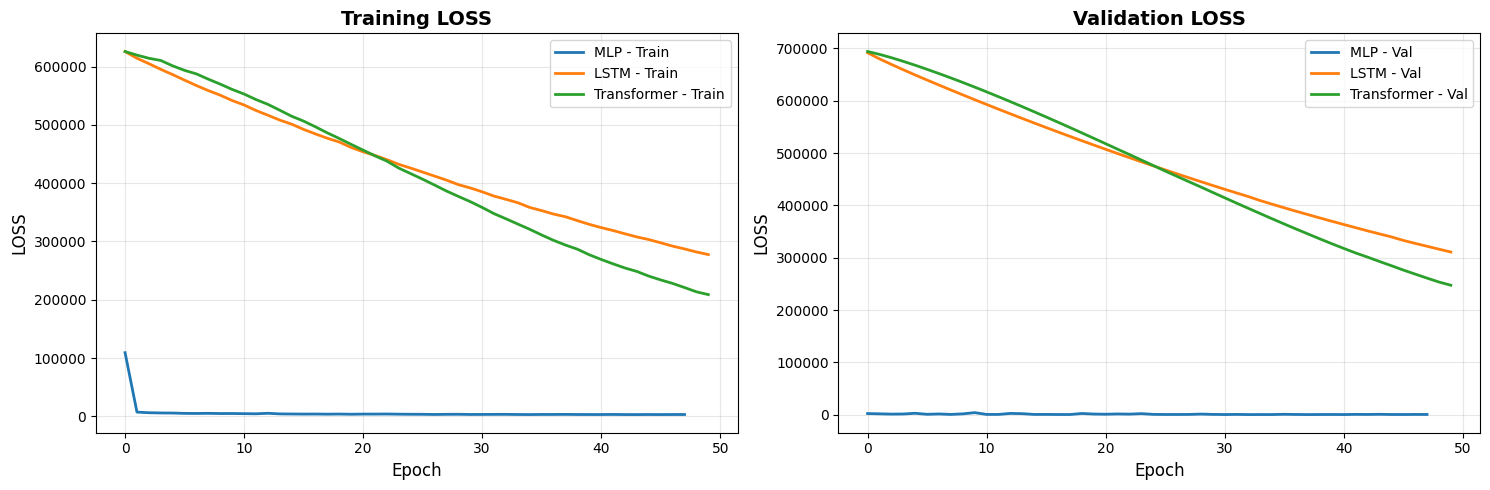

✓ Plot saved: training_history_loss.png


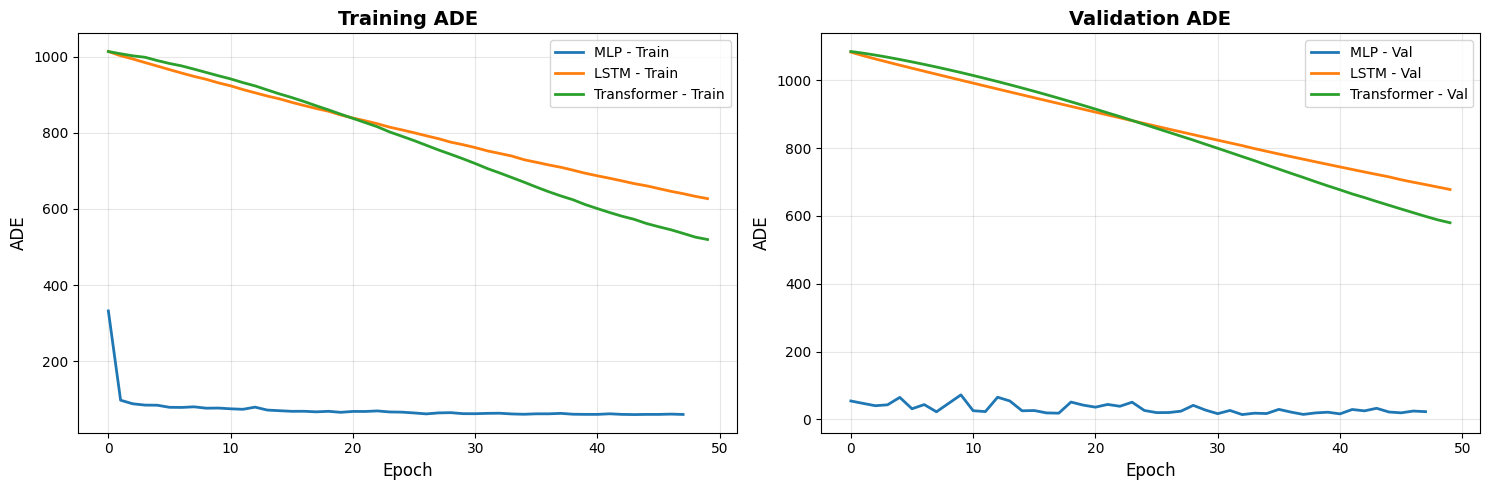

✓ Plot saved: training_history_ade.png


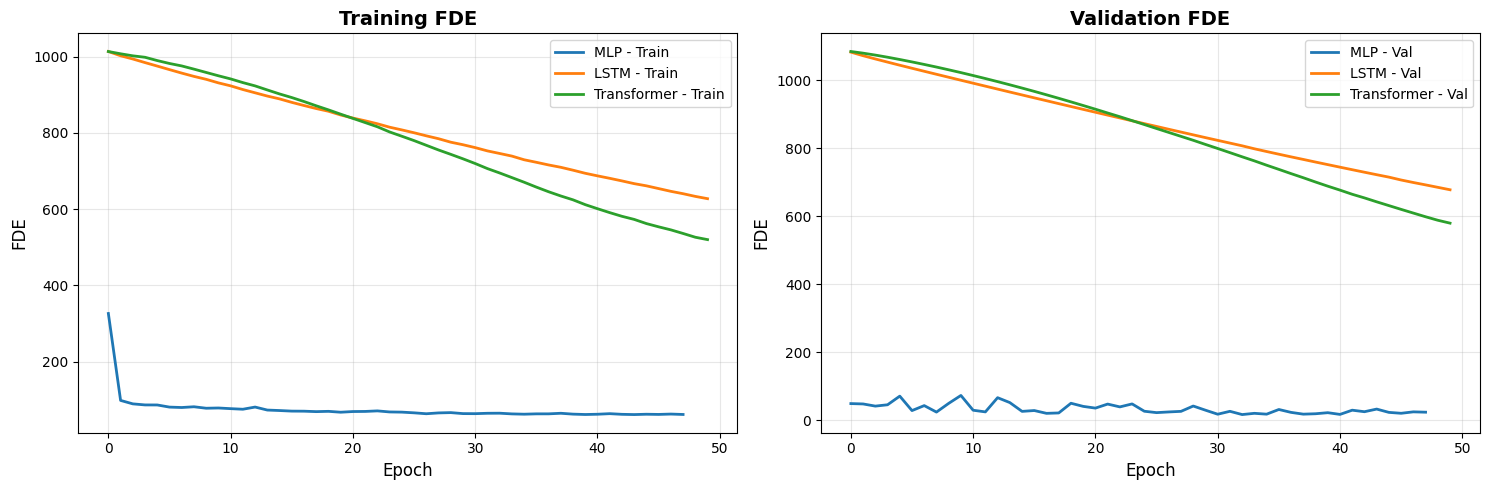

✓ Plot saved: training_history_fde.png


In [31]:
# Cell 22: Plot Training History
def plot_training_history(histories, metric='loss'):
    """
    Plot training history for all models

    Args:
        histories: dict of {model_name: history}
        metric: 'loss', 'ade', or 'fde'
    """
    plt.figure(figsize=(15, 5))

    # Training metric
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        train_key = f'train_{metric}'
        plt.plot(history[train_key], label=f'{name} - Train', linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.upper(), fontsize=12)
    plt.title(f'Training {metric.upper()}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Validation metric
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        val_key = f'val_{metric}'
        plt.plot(history[val_key], label=f'{name} - Val', linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.upper(), fontsize=12)
    plt.title(f'Validation {metric.upper()}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'training_history_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Plot saved: training_history_{metric}.png")

# Plot all metrics
histories = {
    'MLP': history_mlp,
    'LSTM': history_lstm,
    'Transformer': history_transformer
}

plot_training_history(histories, 'loss')
plot_training_history(histories, 'ade')
plot_training_history(histories, 'fde')

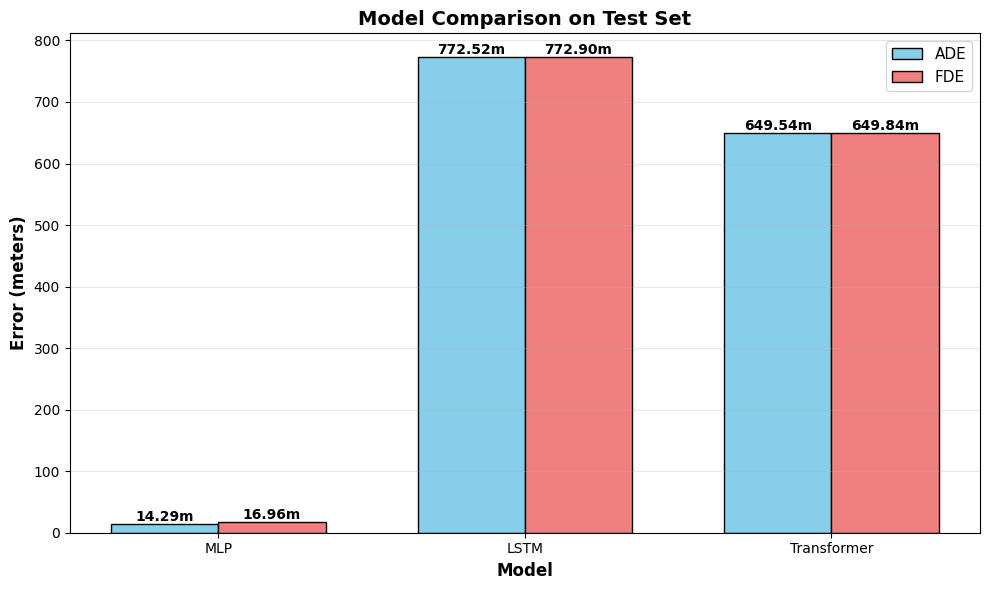

✓ Plot saved: model_comparison.png


In [32]:
# Cell 23: Comparison Bar Chart
def plot_comparison_bar_chart(all_results):
    """Plot comparison bar chart for all models"""
    models = list(all_results.keys())
    ade_scores = [all_results[m]['test_ade'] for m in models]
    fde_scores = [all_results[m]['test_fde'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, ade_scores, width, label='ADE', color='skyblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, fde_scores, width, label='FDE', color='lightcoral', edgecolor='black')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}m',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Error (meters)', fontsize=12, fontweight='bold')
    ax.set_title('Model Comparison on Test Set', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: model_comparison.png")

plot_comparison_bar_chart(all_results)

In [33]:
# Cell 24: Results Summary Table
def print_results_table(all_results):
    """Print formatted results table"""
    print("\n" + "="*90)
    print(" "*30 + "FINAL RESULTS SUMMARY")
    print("="*90)
    print(f"{'Model':<35} {'Test Loss':<15} {'ADE (m)':<15} {'FDE (m)':<15}")
    print("-"*90)

    for model_name, results in all_results.items():
        print(f"{model_name:<35} "
              f"{results['test_loss']:<15.6f} "
              f"{results['test_ade']:<15.4f} "
              f"{results['test_fde']:<15.4f}")

    print("="*90)

    # Find best model for each metric
    best_ade_model = min(all_results.items(), key=lambda x: x[1]['test_ade'])
    best_fde_model = min(all_results.items(), key=lambda x: x[1]['test_fde'])

    print("\n" + "="*90)
    print("BEST MODELS:")
    print(f"  Best ADE: {best_ade_model[0]} ({best_ade_model[1]['test_ade']:.4f}m)")
    print(f"  Best FDE: {best_fde_model[0]} ({best_fde_model[1]['test_fde']:.4f}m)")
    print("="*90 + "\n")

print_results_table(all_results)


                              FINAL RESULTS SUMMARY
Model                               Test Loss       ADE (m)         FDE (m)        
------------------------------------------------------------------------------------------
MLP                                 134.863163      14.2923         16.9567        
LSTM                                383022.180398   772.5235        772.9004       
Transformer                         288908.370028   649.5380        649.8419       

BEST MODELS:
  Best ADE: MLP (14.2923m)
  Best FDE: MLP (16.9567m)



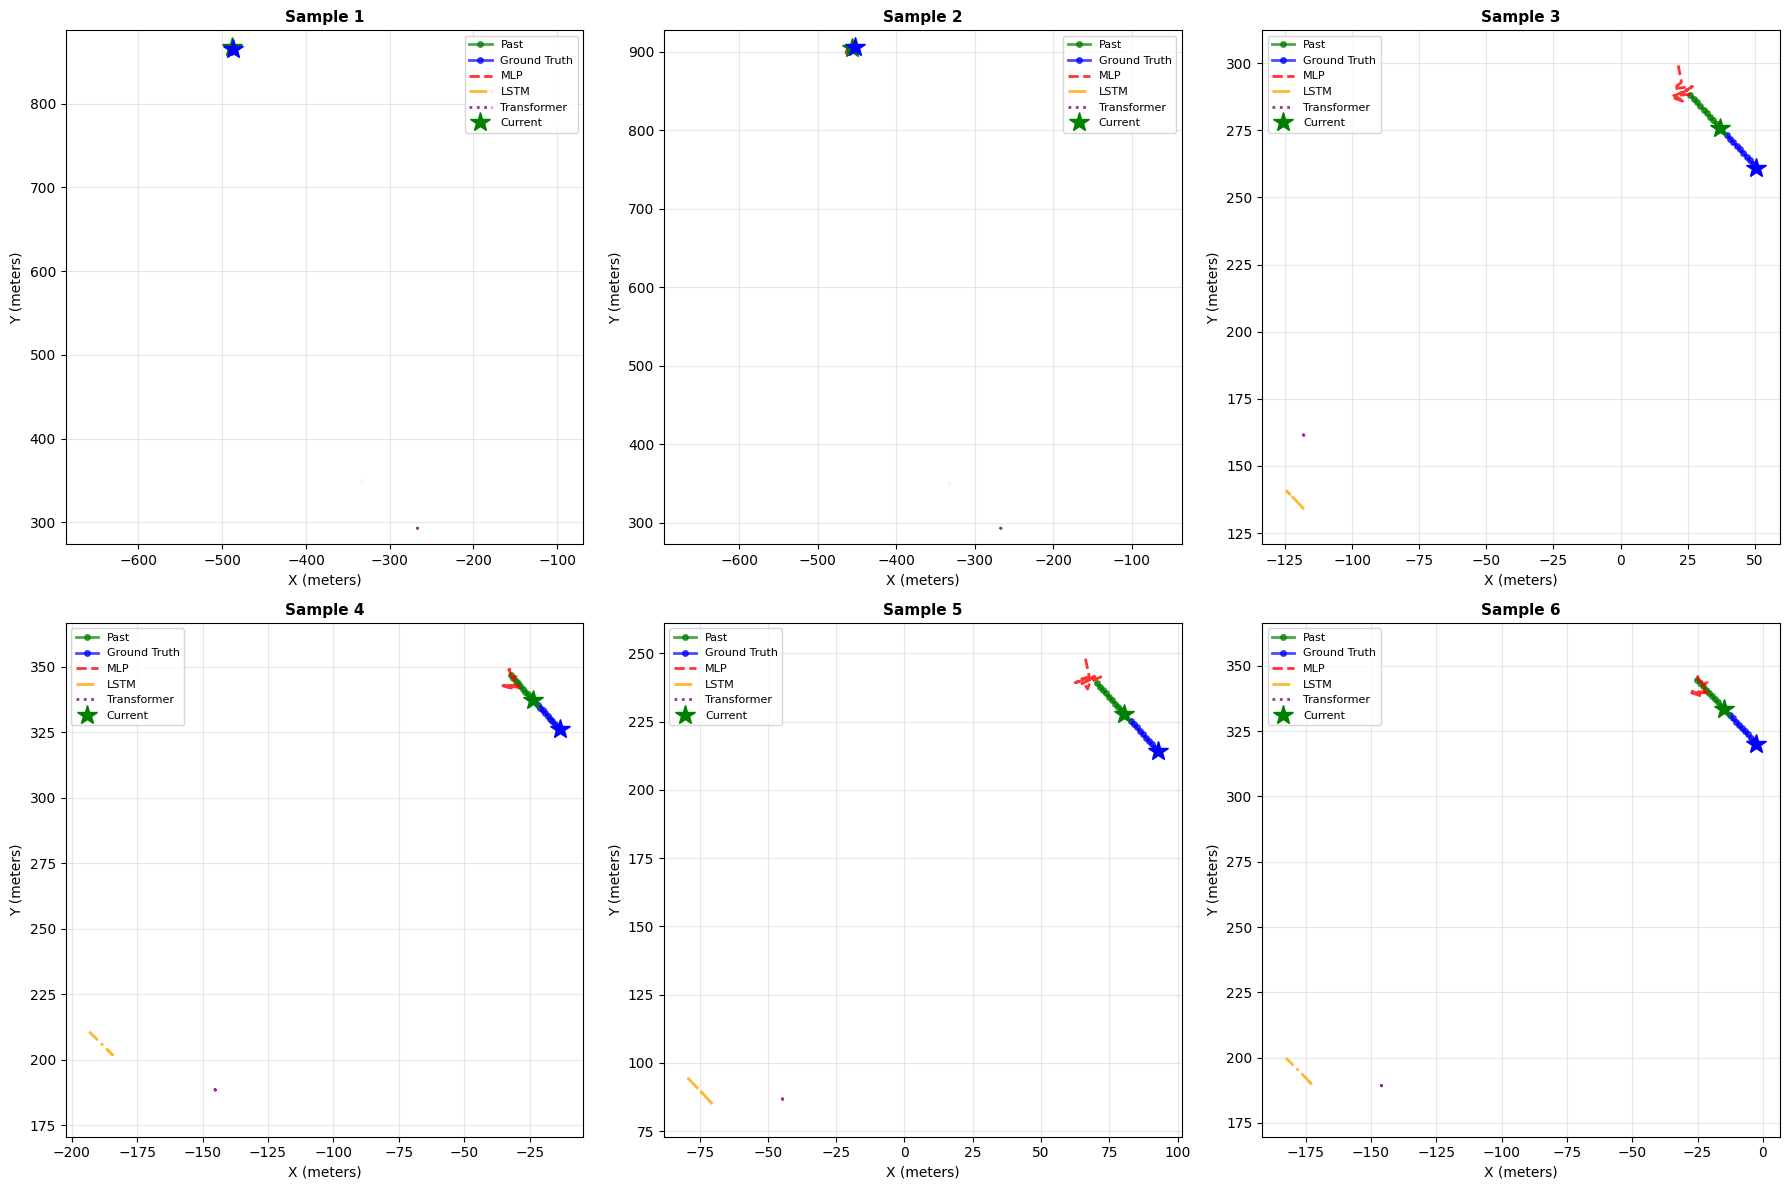

✓ Plot saved: sample_predictions.png


In [34]:
# Cell 25: Visualize Sample Predictions
def visualize_predictions(all_results, num_samples=6):
    """
    Visualize trajectory predictions for sample agents

    Args:
        all_results: dict of results from all models
        num_samples: number of samples to visualize
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Get samples from first model (all models have same input/target)
    first_model = list(all_results.keys())[0]
    inputs = all_results[first_model]['inputs'][:num_samples]
    targets = all_results[first_model]['targets'][:num_samples]

    for idx in range(num_samples):
        ax = axes[idx]

        # Plot past trajectory (input)
        past = inputs[idx]
        ax.plot(past[:, 0], past[:, 1],
               'o-', linewidth=2, markersize=4,
               color='green', label='Past', alpha=0.7)

        # Plot ground truth future
        future = targets[idx]
        ax.plot(future[:, 0], future[:, 1],
               'o-', linewidth=2, markersize=4,
               color='blue', label='Ground Truth', alpha=0.7)

        # Plot predictions from all models
        colors = ['red', 'orange', 'purple']
        linestyles = ['--', '-.', ':']

        for (model_name, results), color, ls in zip(all_results.items(), colors, linestyles):
            pred = results['predictions'][idx]
            ax.plot(pred[:, 0], pred[:, 1],
                   ls, linewidth=2,
                   color=color, label=model_name, alpha=0.8)

        # Mark start and end points
        ax.plot(past[-1, 0], past[-1, 1], 'g*', markersize=15, label='Current')
        ax.plot(future[-1, 0], future[-1, 1], 'b*', markersize=15)

        ax.set_xlabel('X (meters)', fontsize=10)
        ax.set_ylabel('Y (meters)', fontsize=10)
        ax.set_title(f'Sample {idx+1}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='best')
        ax.axis('equal')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: sample_predictions.png")

visualize_predictions(all_results, num_samples=6)

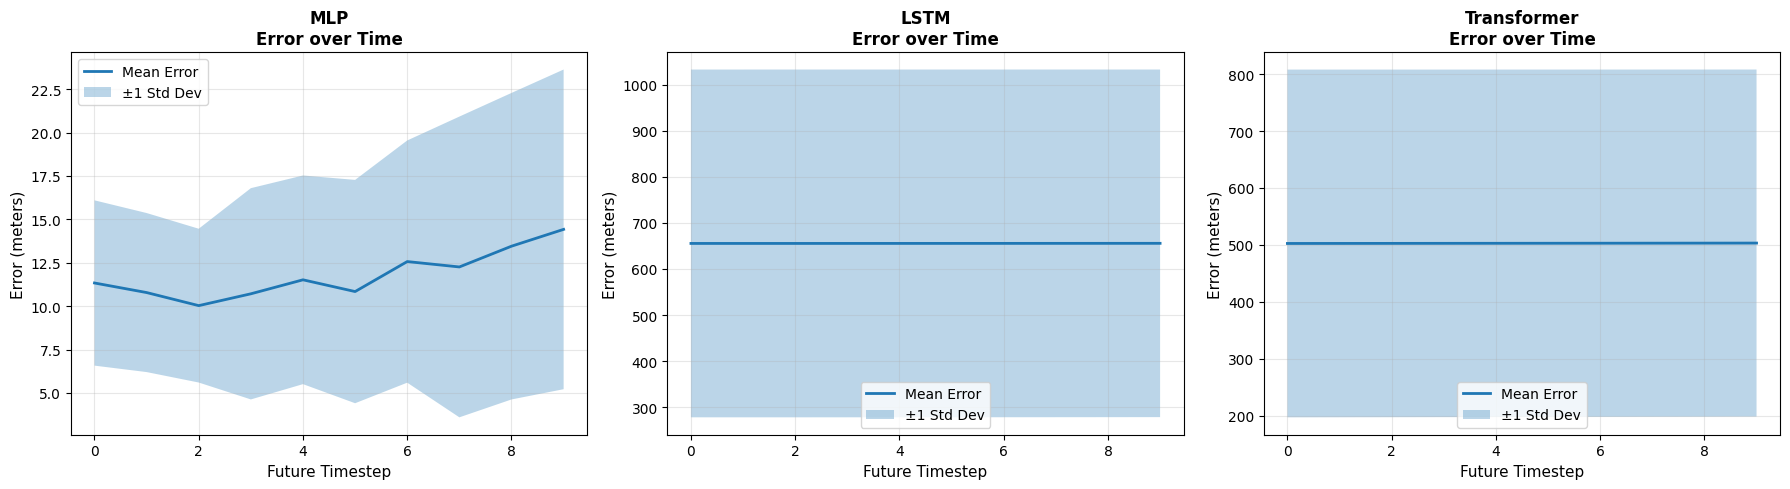

✓ Plot saved: error_distribution.png


In [35]:
# Cell 26: Error Distribution
def plot_error_distribution(all_results):
    """Plot error distribution for each model"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (model_name, results) in enumerate(all_results.items()):
        ax = axes[idx]

        predictions = results['predictions']
        targets = results['targets']

        # Calculate errors per sample
        errors = np.sqrt(((predictions - targets) ** 2).sum(axis=-1))  # [num_samples, future_len]

        # Plot error over time
        mean_errors = errors.mean(axis=0)
        std_errors = errors.std(axis=0)
        timesteps = np.arange(len(mean_errors))

        ax.plot(timesteps, mean_errors, linewidth=2, label='Mean Error')
        ax.fill_between(timesteps,
                        mean_errors - std_errors,
                        mean_errors + std_errors,
                        alpha=0.3, label='±1 Std Dev')

        ax.set_xlabel('Future Timestep', fontsize=11)
        ax.set_ylabel('Error (meters)', fontsize=11)
        ax.set_title(f'{model_name}\nError over Time', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plot saved: error_distribution.png")

plot_error_distribution(all_results)

#SAVE RESULT

In [36]:
# Cell 27: Save all results to JSON
import json

def save_results_to_json(all_results, histories, filename='results_summary.json'):
    """Save all results and training history to JSON"""

    # Prepare data for JSON (remove numpy arrays)
    json_data = {
        'test_results': {
            model_name: {
                'test_loss': float(results['test_loss']),
                'test_ade': float(results['test_ade']),
                'test_fde': float(results['test_fde'])
            }
            for model_name, results in all_results.items()
        },
        'training_history': {
            model_name: {
                'train_loss': [float(x) for x in history['train_loss']],
                'val_loss': [float(x) for x in history['val_loss']],
                'train_ade': [float(x) for x in history['train_ade']],
                'val_ade': [float(x) for x in history['val_ade']],
                'train_fde': [float(x) for x in history['train_fde']],
                'val_fde': [float(x) for x in history['val_fde']],
                'final_epoch': len(history['train_loss'])
            }
            for model_name, history in histories.items()
        },
        'config': {
            'PAST_LEN': config.PAST_LEN,
            'FUTURE_LEN': config.FUTURE_LEN,
            'BATCH_SIZE': config.BATCH_SIZE,
            'LEARNING_RATE': config.LEARNING_RATE,
            'NUM_EPOCHS': config.NUM_EPOCHS
        }
    }

    with open(filename, 'w') as f:
        json.dump(json_data, f, indent=2)

    print(f"✓ Results saved to: {filename}")

save_results_to_json(all_results, histories)

✓ Results saved to: results_summary.json


In [39]:
# Cell 28: Create comprehensive report
def create_report():
    """Create a comprehensive markdown report"""

    report = f"""
# Trajectory Prediction - Final Report

## Project Overview
- **Task**: Multi-agent trajectory prediction
- **Dataset**: Lyft Level 5
- **Models**: Baseline MLP, LSTM Temporal, Transformer Interaction-Aware

## Configuration
- Past trajectory length: {config.PAST_LEN} timesteps (2 seconds @ 10Hz)
- Future trajectory length: {config.FUTURE_LEN} timesteps (3 seconds @ 10Hz)
- Batch size: {config.BATCH_SIZE}
- Learning rate: {config.LEARNING_RATE}
- Max epochs: {config.NUM_EPOCHS}
- Early stopping patience: {config.EARLY_STOP_PATIENCE}

## Dataset Statistics
- Train samples: {len(train_dataset)}
- Validation samples: {len(val_dataset)}
- Test samples: {len(test_dataset)}

## Results

### Test Set Performance

| Model | Test Loss (MSE) | ADE (meters) | FDE (meters) |
|-------|----------------|--------------|--------------|
"""

    for model_name, results in all_results.items():
        report += f"| {model_name} | {results['test_loss']:.6f} | {results['test_ade']:.4f} | {results['test_fde']:.4f} |\n"

    # Find best models
    best_ade = min(all_results.items(), key=lambda x: x[1]['test_ade'])
    best_fde = min(all_results.items(), key=lambda x: x[1]['test_fde'])

    report += f"""
### Best Models
- **Best ADE**: {best_ade[0]} ({best_ade[1]['test_ade']:.4f}m)
- **Best FDE**: {best_fde[0]} ({best_fde[1]['test_fde']:.4f}m)
"""

**FINAL** SUMMARY

In [43]:
# Cell 29: Print final summary
print("\n" + "="*90)
print(" "*30 + "PROJECT COMPLETED!")
print("="*90)

print("\nMODELS TRAINED:")
print("  1. ✓ Baseline MLP (No temporal, no interaction)")
print("  2. ✓ LSTM Temporal (With temporal modeling)")
print("  3. ✓ Transformer Interaction-Aware (Temporal + Interaction)")

print("\nEVALUATION METRICS:")
print("  • ADE (Average Displacement Error)")
print("  • FDE (Final Displacement Error)")
print("  • MSE Loss (Train/Val/Test)")

print("\nSAVED ARTIFACTS:")
print("  • Model checkpoints (.pth files)")
print("  • Training history plots")
print("  • Comparison visualizations")
print("  • Sample predictions")
print("  • Comprehensive report (REPORT.md)")
print("  • Results JSON (results_summary.json)")

print("\nBEST MODEL:")
best_model = min(all_results.items(), key=lambda x: x[1]['test_ade'])
print(f"  {best_model[0]}")
print(f"  ADE: {best_model[1]['test_ade']:.4f}m")
print(f"  FDE: {best_model[1]['test_fde']:.4f}m")

print("\n" + "="*90)
print("Thank you for using this notebook!")
print("="*90 + "\n")


                              PROJECT COMPLETED!

MODELS TRAINED:
  1. ✓ Baseline MLP (No temporal, no interaction)
  2. ✓ LSTM Temporal (With temporal modeling)
  3. ✓ Transformer Interaction-Aware (Temporal + Interaction)

EVALUATION METRICS:
  • ADE (Average Displacement Error)
  • FDE (Final Displacement Error)
  • MSE Loss (Train/Val/Test)

SAVED ARTIFACTS:
  • Model checkpoints (.pth files)
  • Training history plots
  • Comparison visualizations
  • Sample predictions
  • Comprehensive report (REPORT.md)
  • Results JSON (results_summary.json)

BEST MODEL:
  MLP
  ADE: 14.2923m
  FDE: 16.9567m

Thank you for using this notebook!

